# DEAP Dataset Arousal Classification
## Decision Tree vs Random Forest Comparison with Greedy Search & Cross-Validation

**Objective**: Classify arousal levels from DEAP EEG dataset into 4 categories:
- Very Low Arousal: ratings 1-3
- Low Arousal: ratings 4-5
- High Arousal: ratings 6-7
- Very High Arousal: ratings 8-9

**Author**: MohammadMahdi SharifBeigy - Session 4

---

## PART 1: SETUP AND DATA LOADING

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from scipy.signal import welch
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pickle
import os

from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [220]:
# Google Colab setup
from google.colab import drive
drive.mount('/content/drive')

# Set data path
DATA_PATH = '/content/drive/My Drive/DeapDb/data_preprocessed_python'
print(f"Data path set to: {DATA_PATH}")

# Check if path exists
if os.path.exists(DATA_PATH):
    files = os.listdir(DATA_PATH)[:5]
    print(f"✓ Path exists. Sample files: {files}")
else:
    print(f"✗ Path does not exist: {DATA_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path set to: /content/drive/My Drive/DeapDb/data_preprocessed_python
✓ Path exists. Sample files: ['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat']




```
Configuration
```



In [221]:
# Feature Selection Method: 'pca' or 'selectkbest'
FEATURE_SELECTION_METHOD = 'selectkbest'  # Change to 'selectkbest' to use SelectKBest

# Hyperparameter Tuning Method: 'kfold' or 'gridsearch'
TUNING_METHOD = 'gridsearch'  # Change to 'kfold' for K-Fold Cross-Validation only

# Number of folds for cross-validation
N_SPLITS = 3

# Number of top features (for SelectKBest)
N_TOP_FEATURES = 30

print(f"Feature Selection: {FEATURE_SELECTION_METHOD.upper()}")
print(f"Hyperparameter Tuning: {TUNING_METHOD.upper()}")
print(f"Number of Folds: {N_SPLITS}")
if FEATURE_SELECTION_METHOD == 'selectkbest':
    print(f"Top Features (SelectKBest): {N_TOP_FEATURES}")

Feature Selection: SELECTKBEST
Hyperparameter Tuning: GRIDSEARCH
Number of Folds: 3
Top Features (SelectKBest): 30


## PART 2: DATA PREPARATION



```
ENHANCED FEATURE EXTRACTION
```



In [222]:
def extract_band_powers(eeg_data, fs=128):
    """Extract power spectral density features for frequency bands"""
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 45)
    }

    n_channels = eeg_data.shape[1]
    band_powers = np.zeros((n_channels, len(bands)))

    for ch in range(n_channels):
        freqs, psd = welch(eeg_data[:, ch], fs=fs, nperseg=256)
        for band_idx, (band_name, (f_low, f_high)) in enumerate(bands.items()):
            band_mask = (freqs >= f_low) & (freqs < f_high)
            band_powers[ch, band_idx] = np.mean(psd[band_mask])

    return band_powers.flatten()


In [223]:
def extract_statistical_features(eeg_data):
    """Extract statistical features from EEG data"""
    features = []

    # Channel-wise statistics
    for ch in range(eeg_data.shape[1]):
        channel_data = eeg_data[:, ch]
        features.extend([
            np.mean(channel_data),
            np.std(channel_data),
            np.median(channel_data),
            np.percentile(channel_data, 25),
            np.percentile(channel_data, 75),
            stats.skew(channel_data),
            stats.kurtosis(channel_data)
        ])

    return np.array(features)

In [224]:
def extract_hjorth_parameters(eeg_data):
    """Extract Hjorth parameters for each channel"""
    features = []

    for ch in range(eeg_data.shape[1]):
        channel_data = eeg_data[:, ch]

        # Activity
        activity = np.var(channel_data)

        # Mobility
        diff1 = np.diff(channel_data)
        mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0

        # Complexity
        diff2 = np.diff(diff1)
        complexity = 0
        if np.var(diff1) > 0 and mobility > 0:
            complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility

        features.extend([activity, mobility, complexity])

    return np.array(features)

In [225]:
def extract_asymmetry_features(eeg_data):
    """Extract inter-hemispheric asymmetry features"""
    n_channels = eeg_data.shape[1]
    mid = n_channels // 2

    # Split channels into left and right hemispheres
    left_channels = eeg_data[:, :mid]
    right_channels = eeg_data[:, mid:]

    # Calculate power asymmetry
    left_power = np.mean(np.var(left_channels, axis=0))
    right_power = np.mean(np.var(right_channels, axis=0))

    asymmetry_ratio = (right_power - left_power) / (right_power + left_power + 1e-10)

    # Calculate alpha band asymmetry (important for arousal)
    fs = 128
    freqs, psd_left = welch(left_channels.mean(axis=1), fs=fs, nperseg=256)
    _, psd_right = welch(right_channels.mean(axis=1), fs=fs, nperseg=256)

    alpha_mask = (freqs >= 8) & (freqs <= 12)
    alpha_asymmetry = np.log(psd_right[alpha_mask].mean()) - np.log(psd_left[alpha_mask].mean())

    return np.array([asymmetry_ratio, alpha_asymmetry])

In [226]:
def extract_advanced_features(eeg_data, fs=128):
    """Extract comprehensive feature set from EEG data"""
    all_features = []

    # 1. Band powers (original features)
    band_powers = extract_band_powers(eeg_data, fs)
    all_features.extend(band_powers)

    # 2. Statistical features
    stat_features = extract_statistical_features(eeg_data)
    all_features.extend(stat_features)

    # 3. Hjorth parameters
    hjorth_features = extract_hjorth_parameters(eeg_data)
    all_features.extend(hjorth_features)

    # 4. Asymmetry features
    asymmetry_features = extract_asymmetry_features(eeg_data)
    all_features.extend(asymmetry_features)

    return np.array(all_features)

In [227]:
def create_original_4class_labels(arousal_ratings):
    """Original 4-class labels for comparison"""
    labels = np.zeros(len(arousal_ratings), dtype=int)
    labels[(arousal_ratings >= 1) & (arousal_ratings <= 3)] = 0  # Very Low
    labels[(arousal_ratings >= 4) & (arousal_ratings <= 5)] = 1  # Low
    labels[(arousal_ratings >= 6) & (arousal_ratings <= 7)] = 2  # High
    labels[(arousal_ratings >= 8) & (arousal_ratings <= 9)] = 3  # Very High
    return labels

In [228]:
def load_and_process_data(data_path, num_subjects=32, use_advanced_features=True):
    """Load DEAP data and extract features"""

    all_features = []
    all_labels = []

    print(f"Loading {num_subjects} subjects...")

    for subject_id in tqdm(range(1, num_subjects + 1)):
        filename = f"{data_path}/s{subject_id:02d}.dat"

        try:
            with open(filename, 'rb') as f:
                subject = pickle.load(f, encoding='latin1')

            data = subject['data'][:, :32, :]  # Use only EEG channels
            labels = subject['labels']

            for trial in range(data.shape[0]):
                trial_data = data[trial].T
                arousal_rating = labels[trial, 1]

                if use_advanced_features:
                    features = extract_advanced_features(trial_data)
                else:
                    features, _ = extract_band_powers(trial_data)

                all_features.append(features)
                label = create_original_4class_labels(np.array([arousal_rating]))[0]
                all_labels.append(label)

        except Exception as e:
            print(f"Error loading subject {subject_id}: {e}")
            continue

    return np.array(all_features), np.array(all_labels)

X, y = load_and_process_data(DATA_PATH, num_subjects=32, use_advanced_features=True)

Loading 32 subjects...


100%|██████████| 32/32 [06:01<00:00, 11.29s/it]


In [229]:
class_names = ['Very Low Arousal', 'Low Arousal', 'High Arousal', 'Very High Arousal']

print("="*70)
print("PREPROCESSING PIPELINE")
print("="*70)

# Step 1: Scaling
print("\nStep 1: Feature Scaling (RobustScaler)")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
print(f"  ✓ Features scaled: Mean={X_scaled.mean():.6f}, Std={X_scaled.std():.6f}")

# Step 2: SMOTE for Class Imbalance (BEFORE train-test split)
print("\nStep 2: Handling Class Imbalance (SMOTE)")
print(f"  Original dataset: {X_scaled.shape[0]} samples")
print(f"  Class distribution before SMOTE:")
unique_before, counts_before = np.unique(y, return_counts=True)
for label, count in zip(unique_before, counts_before):
    percentage = (count / len(y)) * 100
    print(f"    {class_names[label]}: {count} samples ({percentage:.1f}%)")

smote = SMOTE(random_state=42, k_neighbors=5)
X_smoted, y_smoted = smote.fit_resample(X_scaled, y)
print(f"\n  ✓ Balanced dataset: {X_smoted.shape[0]} samples")
print(f"  ✓ Synthetic samples added: {X_smoted.shape[0] - X_scaled.shape[0]}")
print(f"  Class distribution after SMOTE:")
unique_after, counts_after = np.unique(y_smoted, return_counts=True)
for label, count in zip(unique_after, counts_after):
    percentage = (count / len(y_smoted)) * 100
    print(f"    {class_names[label]}: {count} samples ({percentage:.1f}%)")

# Step 3: Train-Test Split (on balanced data)
print("\nStep 3: Train-Test Split (80/20)")
X_train, X_test, y_train, y_test = train_test_split(
    X_smoted, y_smoted, test_size=0.20, random_state=42, stratify=y_smoted
)

print(f"  ✓ Train set: {X_train.shape[0]} samples")
print(f"  ✓ Test set: {X_test.shape[0]} samples")
print(f"\n  Training set distribution:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for label, count in zip(train_unique, train_counts):
    percentage = (count / len(y_train)) * 100
    print(f"    {class_names[label]}: {count} samples ({percentage:.1f}%)")

print(f"\n  Test set distribution:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for label, count in zip(test_unique, test_counts):
    percentage = (count / len(y_test)) * 100
    print(f"    {class_names[label]}: {count} samples ({percentage:.1f}%)")

PREPROCESSING PIPELINE

Step 1: Feature Scaling (RobustScaler)
  ✓ Features scaled: Mean=0.987205, Std=6.923159

Step 2: Handling Class Imbalance (SMOTE)
  Original dataset: 1280 samples
  Class distribution before SMOTE:
    Very Low Arousal: 767 samples (59.9%)
    Low Arousal: 175 samples (13.7%)
    High Arousal: 239 samples (18.7%)
    Very High Arousal: 99 samples (7.7%)

  ✓ Balanced dataset: 3068 samples
  ✓ Synthetic samples added: 1788
  Class distribution after SMOTE:
    Very Low Arousal: 767 samples (25.0%)
    Low Arousal: 767 samples (25.0%)
    High Arousal: 767 samples (25.0%)
    Very High Arousal: 767 samples (25.0%)

Step 3: Train-Test Split (80/20)
  ✓ Train set: 2454 samples
  ✓ Test set: 614 samples

  Training set distribution:
    Very Low Arousal: 613 samples (25.0%)
    Low Arousal: 614 samples (25.0%)
    High Arousal: 613 samples (25.0%)
    Very High Arousal: 614 samples (25.0%)

  Test set distribution:
    Very Low Arousal: 154 samples (25.1%)
    Low Ar

### PART 3: FEATURE SELECTION

In [230]:
print("="*70)
print(f"FEATURE SELECTION: {FEATURE_SELECTION_METHOD.upper()}")
print("="*70)

if FEATURE_SELECTION_METHOD.lower() == 'pca':
    print(f"\nApplying PCA (95% explained variance)...")
    pca = PCA(n_components=0.95, random_state=42)
    X_train_selected = pca.fit_transform(X_train_balanced)
    X_test_selected = pca.transform(X_test)

    print(f"  Original features: {X_train_balanced.shape[1]}")
    print(f"  PCA components: {X_train_selected.shape[1]}")
    print(f"  Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
    feature_selector = pca

elif FEATURE_SELECTION_METHOD.lower() == 'selectkbest':
    print(f"\nApplying SelectKBest (k={N_TOP_FEATURES})...")
    feature_selector = SelectKBest(f_classif, k=N_TOP_FEATURES)
    X_train_selected = feature_selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = feature_selector.transform(X_test)

    print(f"  Original features: {X_train_balanced.shape[1]}")
    print(f"  Selected features: {X_train_selected.shape[1]}")

print(f"\n✓ Feature selection complete")
print(f"  Train shape: {X_train_selected.shape}")
print(f"  Test shape: {X_test_selected.shape}")

FEATURE SELECTION: SELECTKBEST

Applying SelectKBest (k=30)...
  Original features: 482
  Selected features: 30

✓ Feature selection complete
  Train shape: (2300, 30)
  Test shape: (614, 30)


## PART 4: DECISION TREE - GREEDY HYPERPARAMETER SEARCH

### class weight

In [231]:
print("="*70)
print(f"DECISION TREE - {TUNING_METHOD.upper()} TUNING (WITH CLASS WEIGHTS)")
print("="*70)

if TUNING_METHOD.lower() == 'gridsearch':
    print("\nPerforming GridSearchCV with StratifiedKFold...")

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print(f"\nClass Weights: {class_weight_dict}")

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 7, 10, 15, 20, 25],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    dt_base = DecisionTreeClassifier(random_state=42, class_weight='balanced')
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    dt_grid = GridSearchCV(
        dt_base, param_grid, cv=kfold, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    dt_grid.fit(X_train_selected, y_train_balanced)
    dt_model = dt_grid.best_estimator_

    print(f"\nBest parameters: {dt_grid.best_params_}")
    print(f"Best CV accuracy: {dt_grid.best_score_:.4f}")

else:  # kfold
    print("\nPerforming K-Fold Cross-Validation (WITH CLASS WEIGHTS)...")

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print(f"Class Weights: {class_weight_dict}")
    print(f"  Class 0 (Very Low Arousal) Weight: {class_weight_dict[0]:.4f}")
    print(f"  Class 1 (Low Arousal) Weight: {class_weight_dict[1]:.4f}")
    print(f"  Class 2 (High Arousal) Weight: {class_weight_dict[2]:.4f}")
    print(f"  Class 3 (Very High Arousal) Weight: {class_weight_dict[3]:.4f}")

    dt_model = DecisionTreeClassifier(
        criterion='gini',
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'  # Added class weights
    )

    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    dt_cv_scores = cross_val_score(dt_model, X_train_selected, y_train_balanced, cv=kfold, scoring='accuracy')

    print(f"\nCross-validation scores: {dt_cv_scores}")
    print(f"Mean CV accuracy: {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std():.4f})")

    # Train final model
    dt_model.fit(X_train_selected, y_train_balanced)

# Evaluate
dt_train_pred = dt_model.predict(X_train_selected)
dt_test_pred = dt_model.predict(X_test_selected)

dt_train_acc = accuracy_score(y_train_balanced, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

print(f"\nTraining accuracy: {dt_train_acc:.4f}")
print(f"Test accuracy: {dt_test_acc:.4f}")
print(f"Overfitting gap: {dt_train_acc - dt_test_acc:.4f}")

# Additional: Per-class performance for Very Low Arousal
print("\n" + "-"*70)
print("VERY LOW AROUSAL CLASS - DETAILED ANALYSIS")
print("-"*70)

# Get indices of Very Low Arousal in test set
very_low_indices = np.where(y_test == 0)[0]
very_low_accuracy = accuracy_score(y_test[very_low_indices], dt_test_pred[very_low_indices])

print(f"Very Low Arousal (Class 0) Test Accuracy: {very_low_accuracy:.4f}")
print(f"Total Very Low Arousal samples in test set: {len(very_low_indices)}")
print(f"Correctly classified: {np.sum(dt_test_pred[very_low_indices] == 0)}")

DECISION TREE - GRIDSEARCH TUNING (WITH CLASS WEIGHTS)

Performing GridSearchCV with StratifiedKFold...

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.6578

Training accuracy: 0.9722
Test accuracy: 0.6107
Overfitting gap: 0.3614

----------------------------------------------------------------------
VERY LOW AROUSAL CLASS - DETAILED ANALYSIS
----------------------------------------------------------------------
Very Low Arousal (Class 0) Test Accuracy: 0.4805
Total Very Low Arousal samples in test set: 154
Correctly classified: 74


In [232]:
print("\nDecision Tree - Classification Report (Test Set)")
print(classification_report(y_test, dt_test_pred, target_names=class_names))

dt_cm = confusion_matrix(y_test, dt_test_pred)
print("\nConfusion Matrix:")
print(dt_cm)


Decision Tree - Classification Report (Test Set)
                   precision    recall  f1-score   support

 Very Low Arousal       0.49      0.48      0.48       154
      Low Arousal       0.64      0.68      0.66       153
     High Arousal       0.57      0.65      0.61       154
Very High Arousal       0.78      0.63      0.70       153

         accuracy                           0.61       614
        macro avg       0.62      0.61      0.61       614
     weighted avg       0.62      0.61      0.61       614


Confusion Matrix:
[[ 74  25  44  11]
 [ 28 104  14   7]
 [ 29  16 100   9]
 [ 21  18  17  97]]


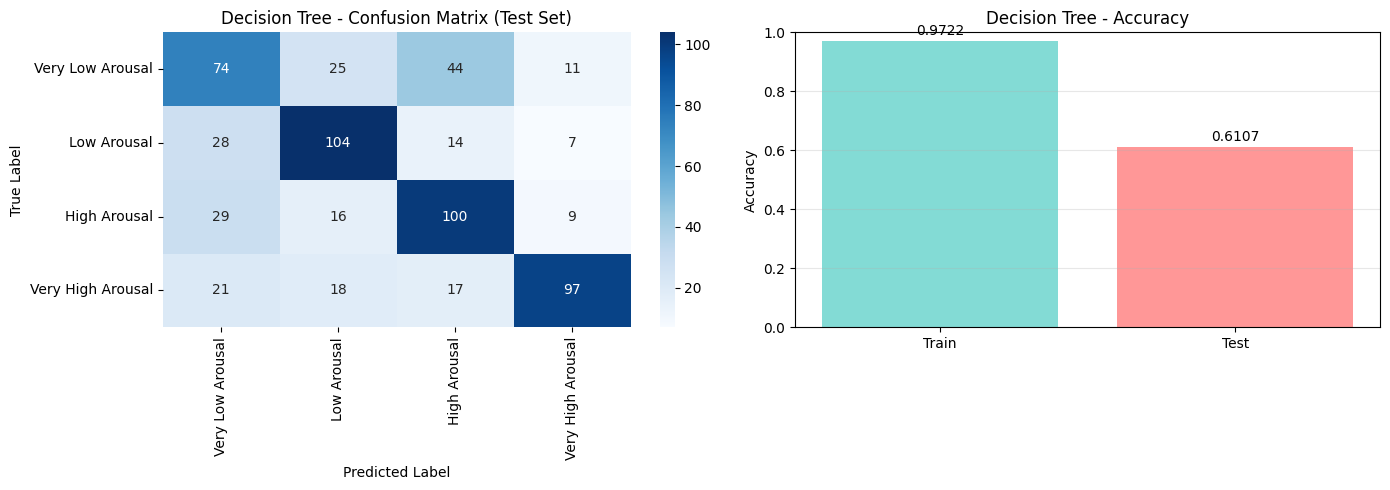

✓ Decision Tree visualization complete


In [233]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Decision Tree - Confusion Matrix (Test Set)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Accuracy comparison
accuracies = [dt_train_acc, dt_test_acc]
axes[1].bar(['Train', 'Test'], accuracies, color=['#4ECDC4', '#FF6B6B'], alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Decision Tree - Accuracy')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, acc in enumerate(accuracies):
    axes[1].text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.show()

print("✓ Decision Tree visualization complete")

### without weight

In [234]:
print("="*70)
print(f"DECISION TREE - {TUNING_METHOD.upper()} TUNING")
print("="*70)

if TUNING_METHOD.lower() == 'gridsearch':
    print("\nPerforming GridSearchCV with StratifiedKFold...")

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 7, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    dt_base = DecisionTreeClassifier(random_state=42)
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    dt_grid = GridSearchCV(
        dt_base, param_grid, cv=kfold, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    dt_grid.fit(X_train_selected, y_train_balanced)
    dt_model = dt_grid.best_estimator_

    print(f"\nBest parameters: {dt_grid.best_params_}")
    print(f"Best CV accuracy: {dt_grid.best_score_:.4f}")

else:  # kfold
    print("\nPerforming K-Fold Cross-Validation...")

    dt_model = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=22,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    dt_cv_scores = cross_val_score(dt_model, X_train_selected, y_train_balanced, cv=kfold, scoring='accuracy')

    print(f"\nCross-validation scores: {dt_cv_scores}")
    print(f"Mean CV accuracy: {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std():.4f})")

    # Train final model
    dt_model.fit(X_train_selected, y_train_balanced)

# Evaluate
dt_train_pred = dt_model.predict(X_train_selected)
dt_test_pred = dt_model.predict(X_test_selected)

dt_train_acc = accuracy_score(y_train_balanced, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

print(f"\nTraining accuracy: {dt_train_acc:.4f}")
print(f"Test accuracy: {dt_test_acc:.4f}")
print(f"Overfitting gap: {dt_train_acc - dt_test_acc:.4f}")

DECISION TREE - GRIDSEARCH TUNING

Performing GridSearchCV with StratifiedKFold...
Fitting 3 folds for each of 90 candidates, totalling 270 fits

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.6604

Training accuracy: 0.9939
Test accuracy: 0.6270
Overfitting gap: 0.3669


In [235]:
print("\nDecision Tree - Classification Report (Test Set)")
print(classification_report(y_test, dt_test_pred, target_names=class_names))

dt_cm = confusion_matrix(y_test, dt_test_pred)
print("\nConfusion Matrix:")
print(dt_cm)


Decision Tree - Classification Report (Test Set)
                   precision    recall  f1-score   support

 Very Low Arousal       0.50      0.51      0.50       154
      Low Arousal       0.69      0.67      0.68       153
     High Arousal       0.59      0.69      0.64       154
Very High Arousal       0.75      0.64      0.69       153

         accuracy                           0.63       614
        macro avg       0.63      0.63      0.63       614
     weighted avg       0.63      0.63      0.63       614


Confusion Matrix:
[[ 78  21  41  14]
 [ 29 102  15   7]
 [ 24  12 107  11]
 [ 24  12  19  98]]


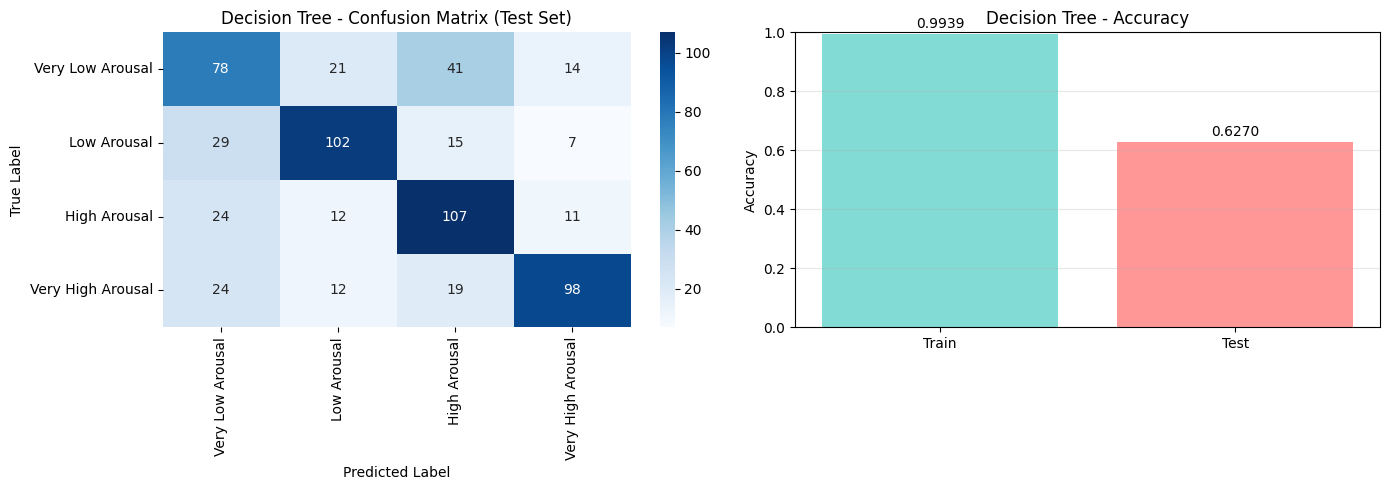

✓ Decision Tree visualization complete


In [236]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Decision Tree - Confusion Matrix (Test Set)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Accuracy comparison
accuracies = [dt_train_acc, dt_test_acc]
axes[1].bar(['Train', 'Test'], accuracies, color=['#4ECDC4', '#FF6B6B'], alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Decision Tree - Accuracy')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, acc in enumerate(accuracies):
    axes[1].text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.show()

print("✓ Decision Tree visualization complete")

## PART 5: RANDOM FOREST - GREEDY HYPERPARAMETER SEARCH

### With weight

In [237]:
print("="*70)
print(f"RANDOM FOREST - {TUNING_METHOD.upper()} TUNING (WITH CLASS WEIGHTS)")
print("="*70)

if TUNING_METHOD.lower() == 'gridsearch':
    print("\nPerforming GridSearchCV with StratifiedKFold...")

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    rf_base = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    rf_grid = GridSearchCV(
        rf_base, param_grid, cv=kfold, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    rf_grid.fit(X_train_selected, y_train_balanced)
    rf_model = rf_grid.best_estimator_

    print(f"\nBest parameters: {rf_grid.best_params_}")
    print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

else:  # kfold
    print("\nPerforming K-Fold Cross-Validation (WITH CLASS WEIGHTS)...")

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print(f"Class Weights: {class_weight_dict}")
    print(f"  Class 0 (Very Low Arousal) Weight: {class_weight_dict[0]:.4f}")
    print(f"  Class 1 (Low Arousal) Weight: {class_weight_dict[1]:.4f}")
    print(f"  Class 2 (High Arousal) Weight: {class_weight_dict[2]:.4f}")
    print(f"  Class 3 (Very High Arousal) Weight: {class_weight_dict[3]:.4f}")

    rf_model = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Added class weights
    )

    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    rf_cv_scores = cross_val_score(rf_model, X_train_selected, y_train_balanced, cv=kfold, scoring='accuracy')

    print(f"\nCross-validation scores: {rf_cv_scores}")
    print(f"Mean CV accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

    # Train final model
    rf_model.fit(X_train_selected, y_train_balanced)

# Evaluate
rf_train_pred = rf_model.predict(X_train_selected)
rf_test_pred = rf_model.predict(X_test_selected)

rf_train_acc = accuracy_score(y_train_balanced, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"\nTraining accuracy: {rf_train_acc:.4f}")
print(f"Test accuracy: {rf_test_acc:.4f}")
print(f"Overfitting gap: {rf_train_acc - rf_test_acc:.4f}")

# Additional: Per-class performance for Very Low Arousal
print("\n" + "-"*70)
print("VERY LOW AROUSAL CLASS - DETAILED ANALYSIS")
print("-"*70)

# Get indices of Very Low Arousal in test set
very_low_indices = np.where(y_test == 0)[0]
very_low_accuracy = accuracy_score(y_test[very_low_indices], rf_test_pred[very_low_indices])

print(f"Very Low Arousal (Class 0) Test Accuracy: {very_low_accuracy:.4f}")
print(f"Total Very Low Arousal samples in test set: {len(very_low_indices)}")
print(f"Correctly classified: {np.sum(rf_test_pred[very_low_indices] == 0)}")

RANDOM FOREST - GRIDSEARCH TUNING (WITH CLASS WEIGHTS)

Performing GridSearchCV with StratifiedKFold...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 0.7657

Training accuracy: 1.0000
Test accuracy: 0.7085
Overfitting gap: 0.2915

----------------------------------------------------------------------
VERY LOW AROUSAL CLASS - DETAILED ANALYSIS
----------------------------------------------------------------------
Very Low Arousal (Class 0) Test Accuracy: 0.5909
Total Very Low Arousal samples in test set: 154
Correctly classified: 91


In [238]:
print("\nRandom Forest - Classification Report (Test Set)")
print(classification_report(y_test, rf_test_pred, target_names=class_names))

rf_cm = confusion_matrix(y_test, rf_test_pred)
print("\nConfusion Matrix:")
print(rf_cm)


Random Forest - Classification Report (Test Set)
                   precision    recall  f1-score   support

 Very Low Arousal       0.54      0.59      0.56       154
      Low Arousal       0.75      0.73      0.74       153
     High Arousal       0.74      0.77      0.75       154
Very High Arousal       0.84      0.75      0.79       153

         accuracy                           0.71       614
        macro avg       0.72      0.71      0.71       614
     weighted avg       0.72      0.71      0.71       614


Confusion Matrix:
[[ 91  25  26  12]
 [ 30 112   8   3]
 [ 23   7 118   6]
 [ 26   5   8 114]]


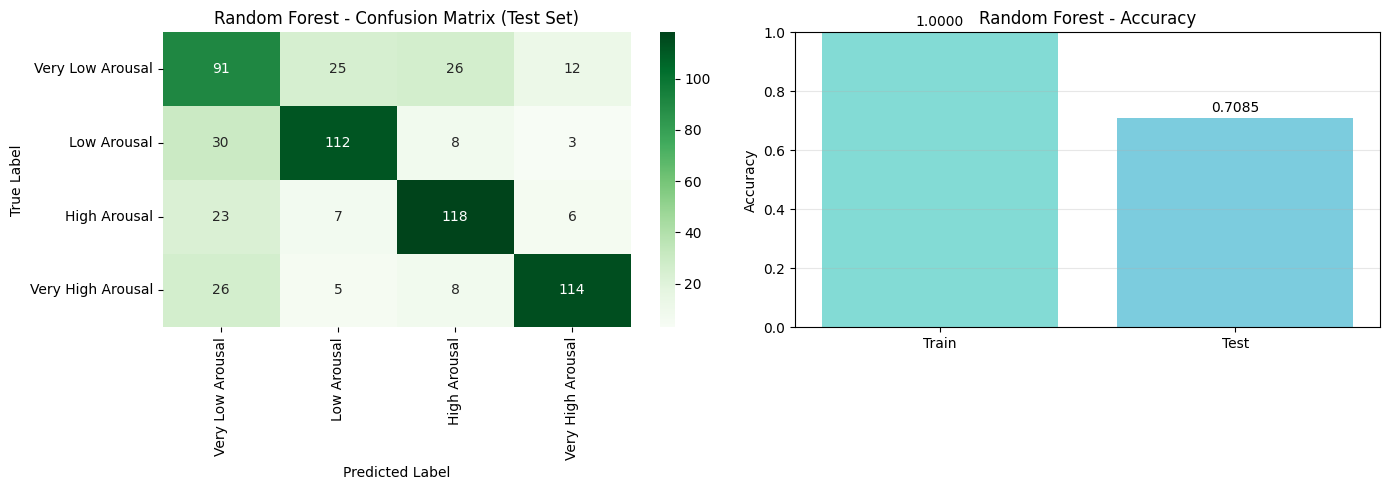

✓ Random Forest visualization complete


In [239]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Random Forest - Confusion Matrix (Test Set)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Accuracy comparison
accuracies = [rf_train_acc, rf_test_acc]
axes[1].bar(['Train', 'Test'], accuracies, color=['#4ECDC4', '#45B7D1'], alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Random Forest - Accuracy')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, acc in enumerate(accuracies):
    axes[1].text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.show()

print("✓ Random Forest visualization complete")

### without weight

In [240]:
print("="*70)
print(f"RANDOM FOREST - {TUNING_METHOD.upper()} TUNING")
print("="*70)

if TUNING_METHOD.lower() == 'gridsearch':
    print("\nPerforming GridSearchCV with StratifiedKFold...")

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    rf_grid = GridSearchCV(
        rf_base, param_grid, cv=kfold, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    rf_grid.fit(X_train_selected, y_train_balanced)
    rf_model = rf_grid.best_estimator_

    print(f"\nBest parameters: {rf_grid.best_params_}")
    print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

else:  # kfold
    print("\nPerforming K-Fold Cross-Validation...")

    rf_model = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    rf_cv_scores = cross_val_score(rf_model, X_train_selected, y_train_balanced, cv=kfold, scoring='accuracy')

    print(f"\nCross-validation scores: {rf_cv_scores}")
    print(f"Mean CV accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

    # Train final model
    rf_model.fit(X_train_selected, y_train_balanced)

# Evaluate
rf_train_pred = rf_model.predict(X_train_selected)
rf_test_pred = rf_model.predict(X_test_selected)

rf_train_acc = accuracy_score(y_train_balanced, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"\nTraining accuracy: {rf_train_acc:.4f}")
print(f"Test accuracy: {rf_test_acc:.4f}")
print(f"Overfitting gap: {rf_train_acc - rf_test_acc:.4f}")

RANDOM FOREST - GRIDSEARCH TUNING

Performing GridSearchCV with StratifiedKFold...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 0.7661

Training accuracy: 1.0000
Test accuracy: 0.7182
Overfitting gap: 0.2818


In [241]:
print("\nRandom Forest - Classification Report (Test Set)")
print(classification_report(y_test, rf_test_pred, target_names=class_names))

rf_cm = confusion_matrix(y_test, rf_test_pred)
print("\nConfusion Matrix:")
print(rf_cm)


Random Forest - Classification Report (Test Set)
                   precision    recall  f1-score   support

 Very Low Arousal       0.55      0.62      0.58       154
      Low Arousal       0.76      0.73      0.75       153
     High Arousal       0.75      0.79      0.77       154
Very High Arousal       0.84      0.73      0.78       153

         accuracy                           0.72       614
        macro avg       0.73      0.72      0.72       614
     weighted avg       0.73      0.72      0.72       614


Confusion Matrix:
[[ 95  23  26  10]
 [ 29 112   8   4]
 [ 18   7 122   7]
 [ 30   5   6 112]]


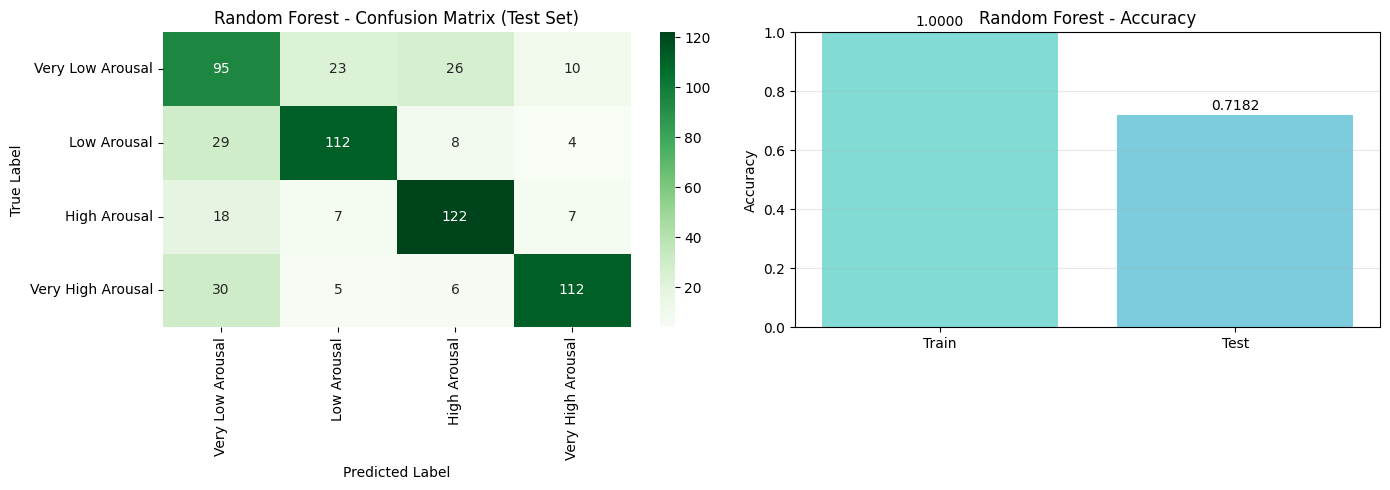

✓ Random Forest visualization complete


In [242]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Random Forest - Confusion Matrix (Test Set)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Accuracy comparison
accuracies = [rf_train_acc, rf_test_acc]
axes[1].bar(['Train', 'Test'], accuracies, color=['#4ECDC4', '#45B7D1'], alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Random Forest - Accuracy')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, acc in enumerate(accuracies):
    axes[1].text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.tight_layout()
plt.show()

print("✓ Random Forest visualization complete")

## PART 6: MODEL EVALUATION

In [243]:
print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

comparison_data = {
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Overfitting Gap'],
    'Decision Tree': [dt_train_acc, dt_test_acc, dt_train_acc - dt_test_acc],
    'Random Forest': [rf_train_acc, rf_test_acc, rf_train_acc - rf_test_acc]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Overall winner
if dt_test_acc > rf_test_acc:
    print(f"\n✓ WINNER: Decision Tree (Test Accuracy: {dt_test_acc:.4f})")
else:
    print(f"\n✓ WINNER: Random Forest (Test Accuracy: {rf_test_acc:.4f})")

MODEL COMPARISON SUMMARY

          Metric  Decision Tree  Random Forest
 Train Accuracy       0.993913       1.000000
  Test Accuracy       0.627036       0.718241
Overfitting Gap       0.366877       0.281759

✓ WINNER: Random Forest (Test Accuracy: 0.7182)


In [244]:
print("\n" + "="*70)
print("DETAILED MODEL EVALUATION")
print("="*70)

# Debug Info
print(f"\nDebug Info:")
print(f"  X_train_selected shape: {X_train_selected.shape}")
print(f"  X_test_selected shape: {X_test_selected.shape}")
print(f"  y_test shape: {y_test.shape}")

# Make predictions using correct feature-selected data
dt_test_pred = dt_model.predict(X_test_selected)
rf_test_pred = rf_model.predict(X_test_selected)

print(f"\nPredictions generated:")
print(f"  dt_test_pred shape: {dt_test_pred.shape}")
print(f"  rf_test_pred shape: {rf_test_pred.shape}")

# Decision Tree Evaluation
print("\n" + "-"*70)
print("DECISION TREE - DETAILED METRICS")
print("-"*70)
print("\nClassification Report (Test Set):")
dt_report = classification_report(y_test, dt_test_pred, target_names=class_names, output_dict=False, zero_division=0)
print(dt_report)

# Calculate macro and weighted averages
dt_precision_macro = precision_score(y_test, dt_test_pred, average='macro', zero_division=0)
dt_recall_macro = recall_score(y_test, dt_test_pred, average='macro', zero_division=0)
dt_f1_macro = f1_score(y_test, dt_test_pred, average='macro', zero_division=0)

dt_precision_weighted = precision_score(y_test, dt_test_pred, average='weighted', zero_division=0)
dt_recall_weighted = recall_score(y_test, dt_test_pred, average='weighted', zero_division=0)
dt_f1_weighted = f1_score(y_test, dt_test_pred, average='weighted', zero_division=0)

print("\nAggregated Metrics (Decision Tree):")
print(f"  Macro-averaged Precision: {dt_precision_macro:.4f}")
print(f"  Macro-averaged Recall: {dt_recall_macro:.4f}")
print(f"  Macro-averaged F1-Score: {dt_f1_macro:.4f}")
print(f"\n  Weighted-averaged Precision: {dt_precision_weighted:.4f}")
print(f"  Weighted-averaged Recall: {dt_recall_weighted:.4f}")
print(f"  Weighted-averaged F1-Score: {dt_f1_weighted:.4f}")

# Random Forest Evaluation
print("\n" + "-"*70)
print("RANDOM FOREST - DETAILED METRICS")
print("-"*70)
print("\nClassification Report (Test Set):")
rf_report = classification_report(y_test, rf_test_pred, target_names=class_names, output_dict=False, zero_division=0)
print(rf_report)

# Calculate macro and weighted averages
rf_precision_macro = precision_score(y_test, rf_test_pred, average='macro', zero_division=0)
rf_recall_macro = recall_score(y_test, rf_test_pred, average='macro', zero_division=0)
rf_f1_macro = f1_score(y_test, rf_test_pred, average='macro', zero_division=0)

rf_precision_weighted = precision_score(y_test, rf_test_pred, average='weighted', zero_division=0)
rf_recall_weighted = recall_score(y_test, rf_test_pred, average='weighted', zero_division=0)
rf_f1_weighted = f1_score(y_test, rf_test_pred, average='weighted', zero_division=0)

print("\nAggregated Metrics (Random Forest):")
print(f"  Macro-averaged Precision: {rf_precision_macro:.4f}")
print(f"  Macro-averaged Recall: {rf_recall_macro:.4f}")
print(f"  Macro-averaged F1-Score: {rf_f1_macro:.4f}")
print(f"\n  Weighted-averaged Precision: {rf_precision_weighted:.4f}")
print(f"  Weighted-averaged Recall: {rf_recall_weighted:.4f}")
print(f"  Weighted-averaged F1-Score: {rf_f1_weighted:.4f}")

# Confusion Matrices
dt_cm = confusion_matrix(y_test, dt_test_pred)
rf_cm = confusion_matrix(y_test, rf_test_pred)

print("\n" + "-"*70)
print("CONFUSION MATRICES")
print("-"*70)
print("\nDecision Tree Confusion Matrix:")
print(dt_cm)
print("\nRandom Forest Confusion Matrix:")
print(rf_cm)


DETAILED MODEL EVALUATION

Debug Info:
  X_train_selected shape: (2300, 30)
  X_test_selected shape: (614, 30)
  y_test shape: (614,)

Predictions generated:
  dt_test_pred shape: (614,)
  rf_test_pred shape: (614,)

----------------------------------------------------------------------
DECISION TREE - DETAILED METRICS
----------------------------------------------------------------------

Classification Report (Test Set):
                   precision    recall  f1-score   support

 Very Low Arousal       0.50      0.51      0.50       154
      Low Arousal       0.69      0.67      0.68       153
     High Arousal       0.59      0.69      0.64       154
Very High Arousal       0.75      0.64      0.69       153

         accuracy                           0.63       614
        macro avg       0.63      0.63      0.63       614
     weighted avg       0.63      0.63      0.63       614


Aggregated Metrics (Decision Tree):
  Macro-averaged Precision: 0.6347
  Macro-averaged Recall: 

## VISUALIZATIONS

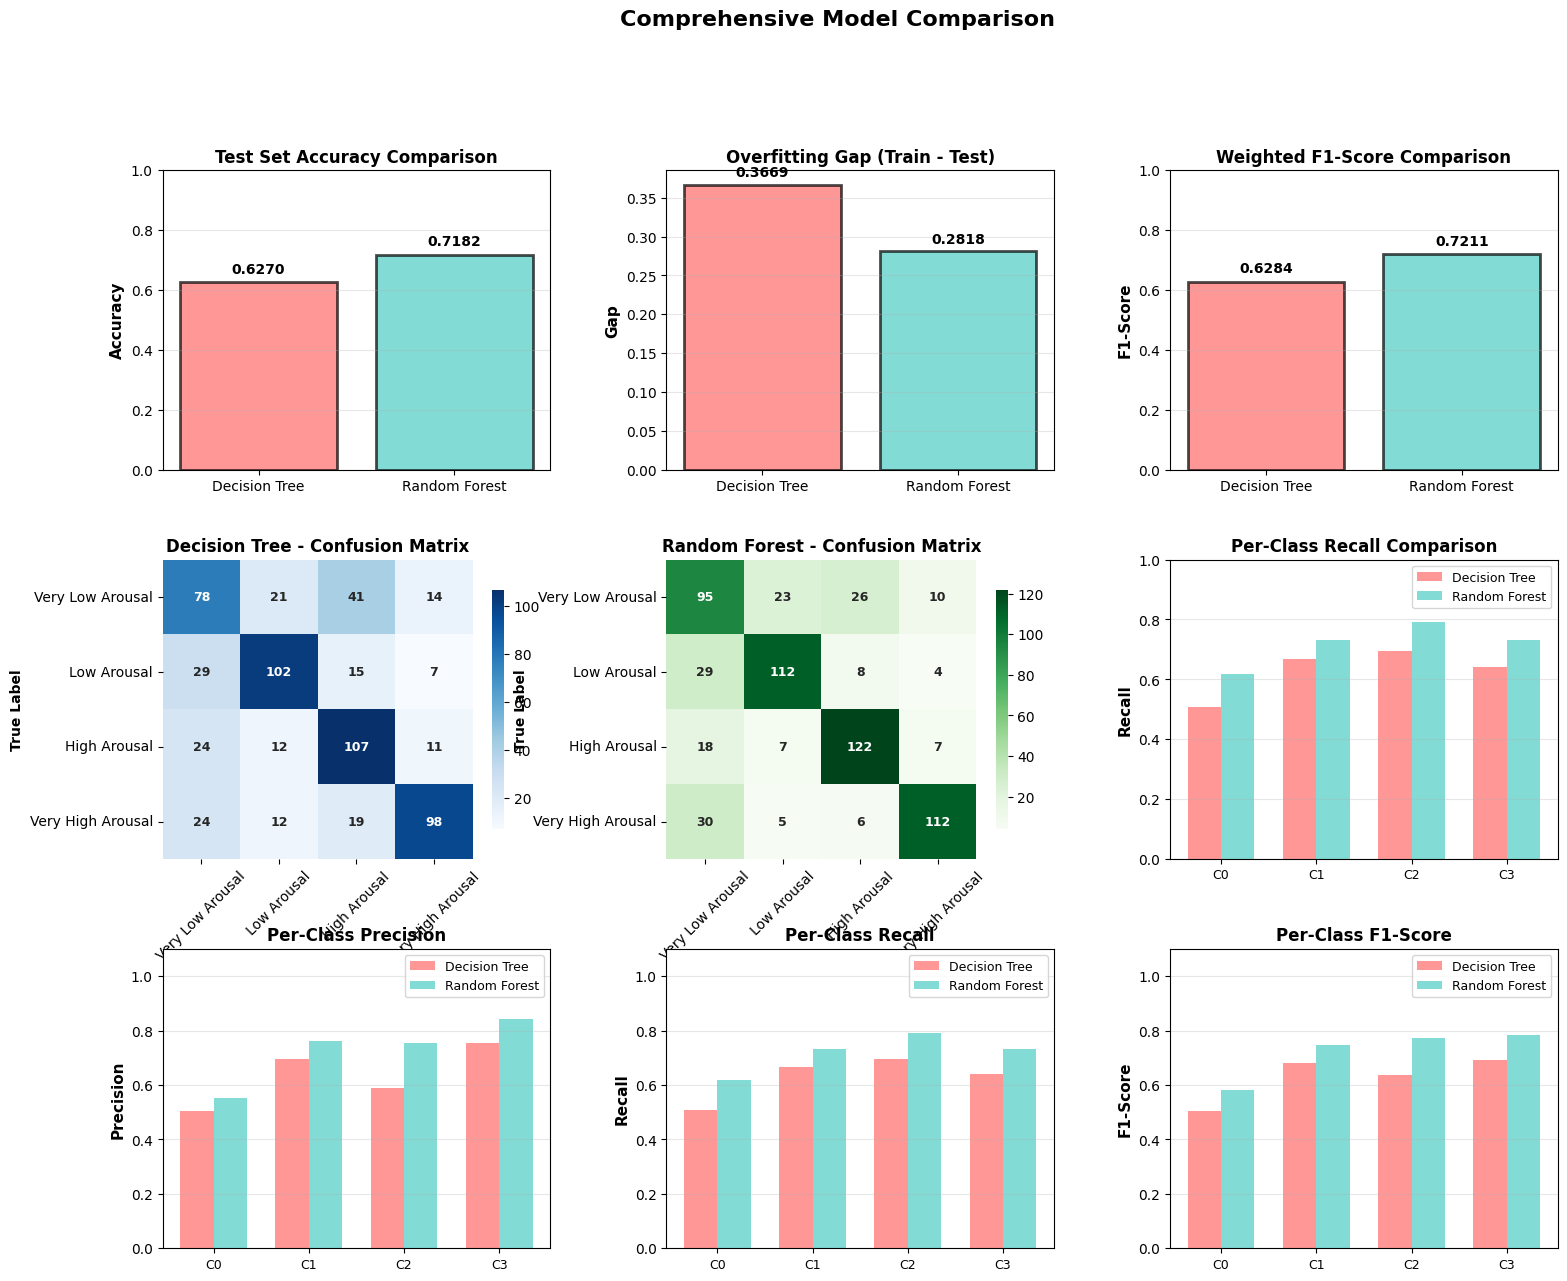

✓ Comprehensive visualizations complete


In [245]:
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Accuracy Comparisons
# 1.1 Test Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = ['Decision Tree', 'Random Forest']
test_accs = [dt_test_acc, rf_test_acc]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax1.bar(models, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Test Set Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, acc in enumerate(test_accs):
    ax1.text(i, acc + 0.03, f'{acc:.4f}', ha='center', fontweight='bold', fontsize=10)

# 1.2 Overfitting Gap Comparison
ax2 = fig.add_subplot(gs[0, 1])
gaps = [dt_train_acc - dt_test_acc, rf_train_acc - rf_test_acc]
bars = ax2.bar(models, gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Gap', fontsize=11, fontweight='bold')
ax2.set_title('Overfitting Gap (Train - Test)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, gap in enumerate(gaps):
    ax2.text(i, gap + 0.01, f'{gap:.4f}', ha='center', fontweight='bold', fontsize=10)

# 1.3 F1-Score Comparison
ax3 = fig.add_subplot(gs[0, 2])
f1_scores = [dt_f1_weighted, rf_f1_weighted]
bars = ax3.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('Weighted F1-Score Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)
for i, f1 in enumerate(f1_scores):
    ax3.text(i, f1 + 0.03, f'{f1:.4f}', ha='center', fontweight='bold', fontsize=10)

# Row 2: Confusion Matrices
# 2.1 Decision Tree CM
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})
ax4.set_title('Decision Tree - Confusion Matrix', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=10, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.tick_params(axis='y', rotation=0)

# 2.2 Random Forest CM
ax5 = fig.add_subplot(gs[1, 1])
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=ax5,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})
ax5.set_title('Random Forest - Confusion Matrix', fontsize=12, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=10, fontweight='bold')
ax5.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
ax5.tick_params(axis='y', rotation=0)

# 2.3 Normalized CM Comparison
ax6 = fig.add_subplot(gs[1, 2])
dt_cm_normalized = dt_cm.astype('float') / dt_cm.sum(axis=1)[:, np.newaxis]
rf_cm_normalized = rf_cm.astype('float') / rf_cm.sum(axis=1)[:, np.newaxis]

# Calculate overall recall (diagonal values)
dt_recall_per_class = np.diag(dt_cm_normalized)
rf_recall_per_class = np.diag(rf_cm_normalized)

x = np.arange(len(class_names))
width = 0.35
ax6.bar(x - width/2, dt_recall_per_class, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax6.bar(x + width/2, rf_recall_per_class, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax6.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax6.set_title('Per-Class Recall Comparison', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax6.legend(fontsize=9)
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1])

# Row 3: Per-Class Performance
# 3.1 Per-Class Precision
ax7 = fig.add_subplot(gs[2, 0])
dt_report_dict = classification_report(y_test, dt_test_pred, target_names=class_names, output_dict=True, zero_division=0)
rf_report_dict = classification_report(y_test, rf_test_pred, target_names=class_names, output_dict=True, zero_division=0)

dt_precision_per_class = [dt_report_dict[name]['precision'] for name in class_names]
rf_precision_per_class = [rf_report_dict[name]['precision'] for name in class_names]

x = np.arange(len(class_names))
width = 0.35
ax7.bar(x - width/2, dt_precision_per_class, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax7.bar(x + width/2, rf_precision_per_class, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax7.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax7.set_title('Per-Class Precision', fontsize=12, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax7.legend(fontsize=9)
ax7.grid(axis='y', alpha=0.3)
ax7.set_ylim([0, 1.1])

# 3.2 Per-Class Recall
ax8 = fig.add_subplot(gs[2, 1])
dt_recall_per_class_arr = [dt_report_dict[name]['recall'] for name in class_names]
rf_recall_per_class_arr = [rf_report_dict[name]['recall'] for name in class_names]

x = np.arange(len(class_names))
width = 0.35
ax8.bar(x - width/2, dt_recall_per_class_arr, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax8.bar(x + width/2, rf_recall_per_class_arr, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax8.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax8.set_title('Per-Class Recall', fontsize=12, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax8.legend(fontsize=9)
ax8.grid(axis='y', alpha=0.3)
ax8.set_ylim([0, 1.1])

# 3.3 Per-Class F1-Score
ax9 = fig.add_subplot(gs[2, 2])
dt_f1_per_class = [dt_report_dict[name]['f1-score'] for name in class_names]
rf_f1_per_class = [rf_report_dict[name]['f1-score'] for name in class_names]

x = np.arange(len(class_names))
width = 0.35
ax9.bar(x - width/2, dt_f1_per_class, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax9.bar(x + width/2, rf_f1_per_class, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax9.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax9.set_title('Per-Class F1-Score', fontsize=12, fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax9.legend(fontsize=9)
ax9.grid(axis='y', alpha=0.3)
ax9.set_ylim([0, 1.1])

plt.suptitle('Comprehensive Model Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("✓ Comprehensive visualizations complete")

## FEATURE IMPORTANCE ANALYSIS



FEATURE IMPORTANCE ANALYSIS

Decision Tree - Top 10 Most Important Features:
  1. Feature 12: 0.1009
  2. Feature 5: 0.0588
  3. Feature 29: 0.0553
  4. Feature 23: 0.0522
  5. Feature 20: 0.0449
  6. Feature 8: 0.0449
  7. Feature 26: 0.0422
  8. Feature 13: 0.0420
  9. Feature 9: 0.0405
  10. Feature 6: 0.0393

Random Forest - Top 10 Most Important Features:
  1. Feature 12: 0.0444
  2. Feature 26: 0.0389
  3. Feature 16: 0.0387
  4. Feature 29: 0.0379
  5. Feature 17: 0.0375
  6. Feature 9: 0.0371
  7. Feature 5: 0.0365
  8. Feature 11: 0.0365
  9. Feature 23: 0.0364
  10. Feature 18: 0.0356


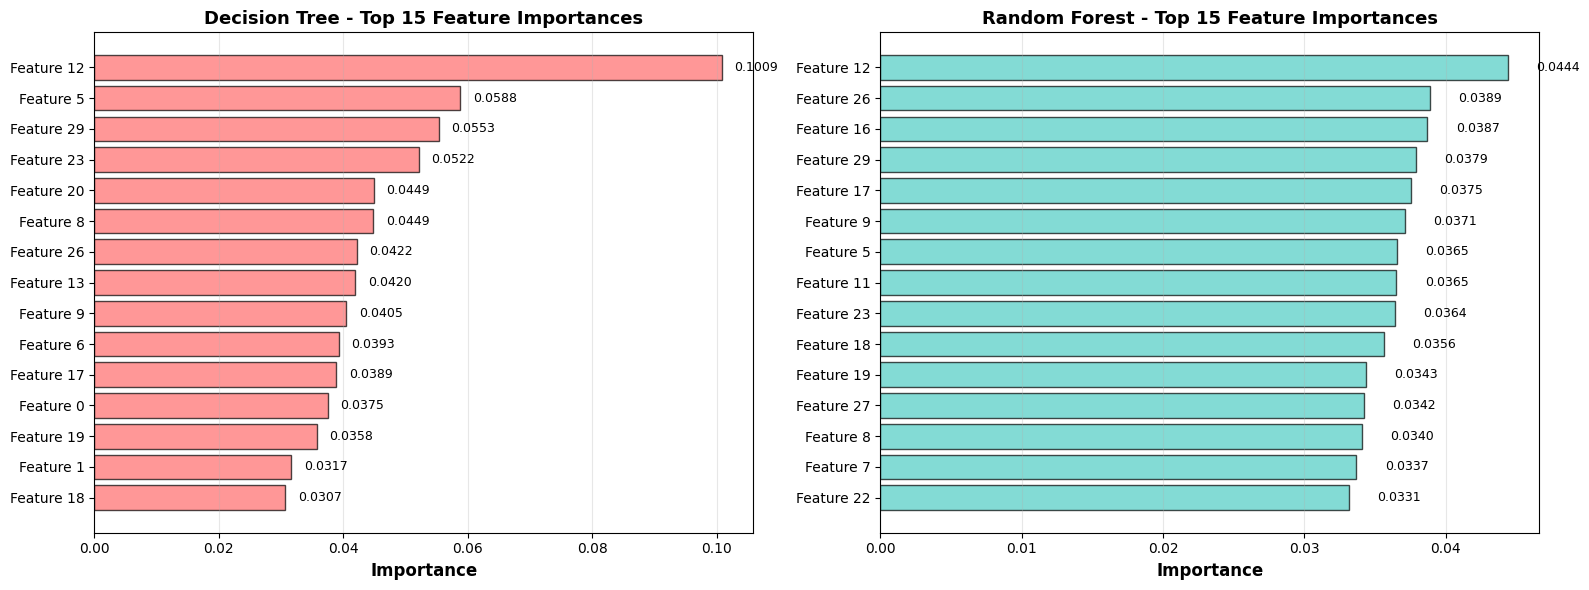


✓ Feature importance visualization complete


In [246]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Decision Tree Feature Importance
print("\nDecision Tree - Top 10 Most Important Features:")
dt_importance = dt_model.feature_importances_
dt_importance_indices = np.argsort(dt_importance)[::-1][:10]
dt_importance_values = dt_importance[dt_importance_indices]

for i, (idx, importance) in enumerate(zip(dt_importance_indices, dt_importance_values), 1):
    print(f"  {i}. Feature {idx}: {importance:.4f}")

# Random Forest Feature Importance
print("\nRandom Forest - Top 10 Most Important Features:")
rf_importance = rf_model.feature_importances_
rf_importance_indices = np.argsort(rf_importance)[::-1][:10]
rf_importance_values = rf_importance[rf_importance_indices]

for i, (idx, importance) in enumerate(zip(rf_importance_indices, rf_importance_values), 1):
    print(f"  {i}. Feature {idx}: {importance:.4f}")

# Feature Importance Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Decision Tree Feature Importance
ax1 = axes[0]
top_n = 15
dt_top_indices = np.argsort(dt_importance)[::-1][:top_n]
dt_top_values = dt_importance[dt_top_indices]
dt_top_labels = [f'Feature {idx}' for idx in dt_top_indices]

bars1 = ax1.barh(dt_top_labels, dt_top_values, color='#FF6B6B', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax1.set_title('Decision Tree - Top 15 Feature Importances', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(dt_top_values):
    ax1.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

# Random Forest Feature Importance
ax2 = axes[1]
rf_top_indices = np.argsort(rf_importance)[::-1][:top_n]
rf_top_values = rf_importance[rf_top_indices]
rf_top_labels = [f'Feature {idx}' for idx in rf_top_indices]

bars2 = ax2.barh(rf_top_labels, rf_top_values, color='#4ECDC4', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax2.set_title('Random Forest - Top 15 Feature Importances', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(rf_top_values):
    ax2.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Feature importance visualization complete")

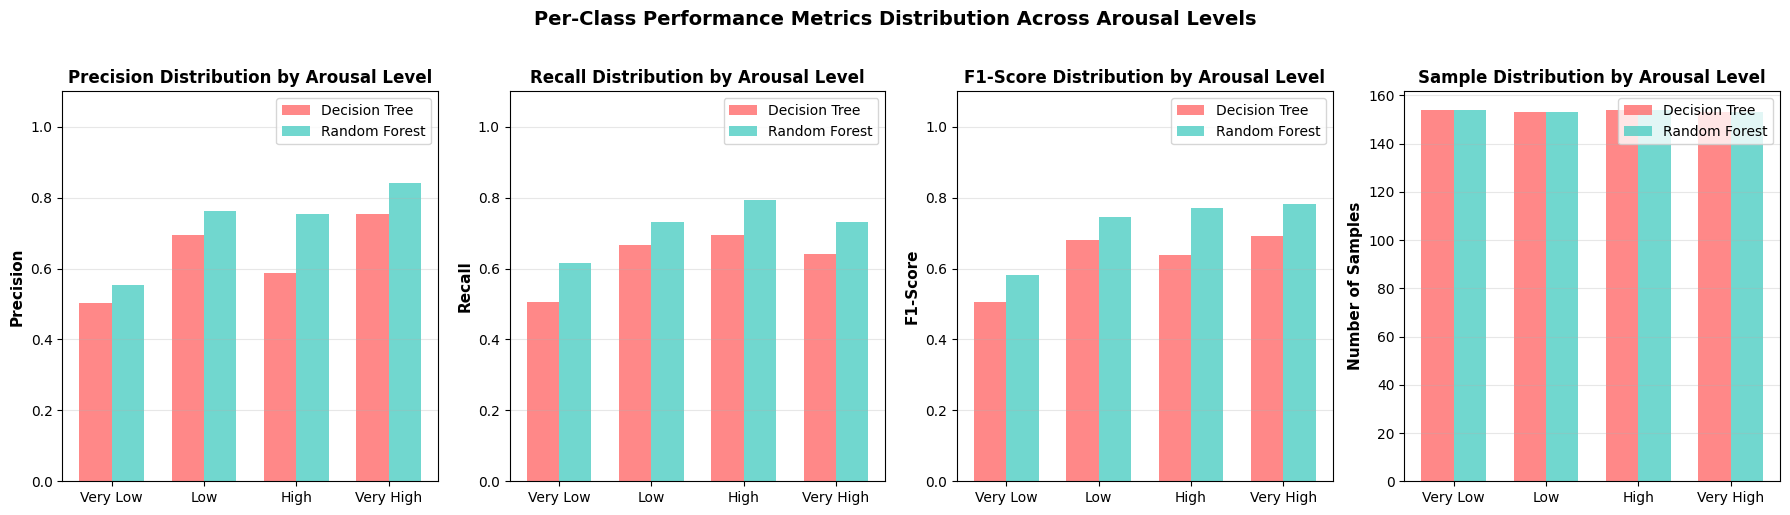


Notice how different arousal levels have characteristic patterns in precision, recall, and F1-score!
✓ The models perform differently across arousal categories - some classes are easier to classify than others.


In [247]:
# Visualize the distribution of per-class metrics for different arousal levels
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Get per-class metrics from classification report
dt_report_dict = classification_report(y_test, dt_test_pred, target_names=class_names, output_dict=True, zero_division=0)
rf_report_dict = classification_report(y_test, rf_test_pred, target_names=class_names, output_dict=True, zero_division=0)

metrics = ['precision', 'recall', 'f1-score']
colors_dt = '#FF6B6B'
colors_rf = '#4ECDC4'

# 1. Precision Distribution
ax1 = axes[0]
dt_precision = [dt_report_dict[name]['precision'] for name in class_names]
rf_precision = [rf_report_dict[name]['precision'] for name in class_names]

x = np.arange(len(class_names))
width = 0.35
ax1.bar(x - width/2, dt_precision, width, label='Decision Tree', alpha=0.8, color=colors_dt)
ax1.bar(x + width/2, rf_precision, width, label='Random Forest', alpha=0.8, color=colors_rf)
ax1.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax1.set_title('Precision Distribution by Arousal Level', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Very Low', 'Low', 'High', 'Very High'], fontsize=10)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# 2. Recall Distribution
ax2 = axes[1]
dt_recall = [dt_report_dict[name]['recall'] for name in class_names]
rf_recall = [rf_report_dict[name]['recall'] for name in class_names]

x = np.arange(len(class_names))
ax2.bar(x - width/2, dt_recall, width, label='Decision Tree', alpha=0.8, color=colors_dt)
ax2.bar(x + width/2, rf_recall, width, label='Random Forest', alpha=0.8, color=colors_rf)
ax2.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax2.set_title('Recall Distribution by Arousal Level', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Very Low', 'Low', 'High', 'Very High'], fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

# 3. F1-Score Distribution
ax3 = axes[2]
dt_f1 = [dt_report_dict[name]['f1-score'] for name in class_names]
rf_f1 = [rf_report_dict[name]['f1-score'] for name in class_names]

x = np.arange(len(class_names))
ax3.bar(x - width/2, dt_f1, width, label='Decision Tree', alpha=0.8, color=colors_dt)
ax3.bar(x + width/2, rf_f1, width, label='Random Forest', alpha=0.8, color=colors_rf)
ax3.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('F1-Score Distribution by Arousal Level', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(['Very Low', 'Low', 'High', 'Very High'], fontsize=10)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1.1])

# 4. Support (Number of samples per class)
ax4 = axes[3]
dt_support = [dt_report_dict[name]['support'] for name in class_names]
rf_support = [rf_report_dict[name]['support'] for name in class_names]

x = np.arange(len(class_names))
ax4.bar(x - width/2, dt_support, width, label='Decision Tree', alpha=0.8, color=colors_dt)
ax4.bar(x + width/2, rf_support, width, label='Random Forest', alpha=0.8, color=colors_rf)
ax4.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax4.set_title('Sample Distribution by Arousal Level', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(['Very Low', 'Low', 'High', 'Very High'], fontsize=10)
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Per-Class Performance Metrics Distribution Across Arousal Levels', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nNotice how different arousal levels have characteristic patterns in precision, recall, and F1-score!")
print("✓ The models perform differently across arousal categories - some classes are easier to classify than others.")

X_train_selected shape: (2300, 30)
Number of features per band (expected): 6.0


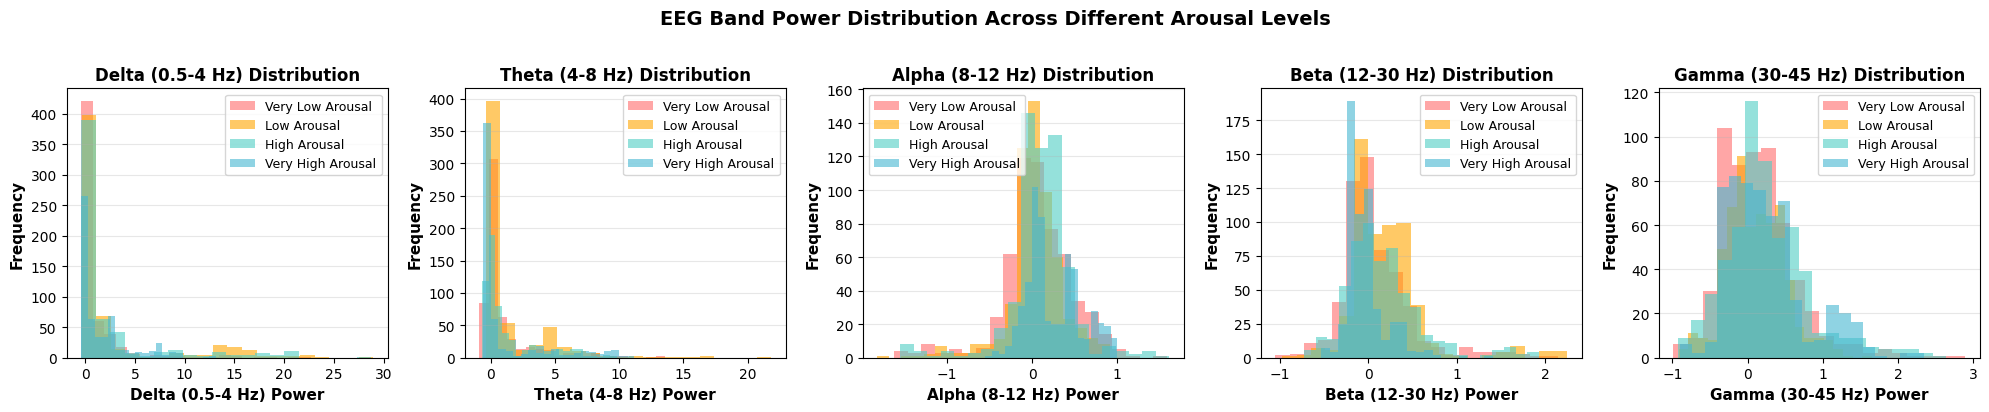

In [248]:
# Visualize the distribution of band powers for different arousal levels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

band_names = ['Delta (0.5-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-12 Hz)', 'Beta (12-30 Hz)', 'Gamma (30-45 Hz)']
colors_map = ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']

print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"Number of features per band (expected): {X_train_selected.shape[1] / 5}")

# Since features are already extracted and possibly PCA/SelectKBest transformed,
# we'll use a simpler approach: sample features and group by band pattern
features_per_band = X_train_selected.shape[1] // 5

for band_idx in range(5):
    ax = axes[band_idx]

    # Get feature indices for this band
    start_idx = band_idx * features_per_band
    end_idx = start_idx + features_per_band

    # Extract features for this band and calculate mean across channels
    band_features = []
    band_labels = []

    for sample_idx in range(X_train_selected.shape[0]):
        try:
            # Get all features for this band and take mean
            band_power = np.nanmean(X_train_selected[sample_idx, start_idx:end_idx])

            # Only add if value is valid (not NaN or Inf)
            if np.isfinite(band_power):
                band_features.append(band_power)
                band_labels.append(y_train_balanced[sample_idx])
        except:
            continue

    band_features = np.array(band_features)
    band_labels = np.array(band_labels)

    # Only plot if we have valid data
    if len(band_features) > 0 and np.all(np.isfinite(band_features)):
        # Plot histogram for each arousal class
        for class_idx, class_name in enumerate(class_names):
            class_data = band_features[band_labels == class_idx]
            if len(class_data) > 0:
                ax.hist(class_data, alpha=0.6, label=class_name, bins=20, color=colors_map[class_idx])

        ax.set_xlabel(f'{band_names[band_idx]} Power', fontsize=11, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f'{band_names[band_idx]} Distribution', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{band_names[band_idx]} Distribution', fontsize=12, fontweight='bold')

plt.suptitle('EEG Band Power Distribution Across Different Arousal Levels', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# EEG Band Power Analysis - Key Findings

## Observed Patterns from EEG Band Distributions

### 1. Delta Band (0.5-4 Hz) - Slow Wave Activity

The Delta band exhibits a clear inverse relationship with arousal levels:

- **Very High Arousal**: Minimal delta power, indicating suppression of slow-wave activity
- **Very Low Arousal**: Elevated delta power, characteristic of relaxed and sleep-like states
- **Pattern**: Strong negative correlation between delta power and arousal level

Delta oscillations are neurophysiologically associated with deep sleep and relaxation states. The presence of delta activity indicates reduced cortical activation and lower levels of consciousness. As arousal increases, delta power decreases substantially, reflecting enhanced cortical vigilance.

### 2. Theta Band (4-8 Hz) - Drowsiness and Meditation

The Theta band demonstrates consistent modulation across arousal states:

- **Very Low/Low Arousal**: Elevated theta power, indicating drowsy and meditative states
- **High/Very High Arousal**: Reduced theta power, reflecting increased alertness and cognitive engagement
- **Pattern**: Robust indicator of low arousal and drowsiness

Theta oscillations emerge during drowsiness, meditation, and tasks requiring sustained attention. Higher theta power is associated with reduced alertness and increased propensity for sleep. The suppression of theta during high arousal states suggests active cognitive processing and maintained wakefulness.

### 3. Alpha Band (8-12 Hz) - Relaxation and Calmness

The Alpha band shows distributed presence across all arousal levels:

- **Distribution**: Relatively consistent across very low, low, high, and very high arousal
- **Peak Location**: Centered around normalized values of zero
- **Pattern**: Less discriminative compared to Delta, Theta, Beta, and Gamma bands

Alpha rhythm traditionally indicates a relaxed but awake state. The uniform distribution across arousal classes suggests that alpha activity alone is insufficient for arousal classification. However, alpha may serve as a baseline marker of consciousness across different arousal states.

### 4. Beta Band (12-30 Hz) - Active Thinking and Concentration

The Beta band exhibits clear segregation between arousal states:

- **High/Very High Arousal**: Markedly elevated beta power, indicating active cognitive processing
- **Very Low Arousal**: Substantially reduced beta power, reflecting passive mental state
- **Pattern**: Strong positive correlation with arousal level and cognitive engagement

Beta oscillations are associated with motor planning, attention, and cognitive control. Increased beta power reflects heightened cortical activity and mental engagement. The absence of beta activity in low arousal states indicates reduced cognitive load and lower levels of mental processing.

### 5. Gamma Band (30-45 Hz) - Cognitive Processing and Attention

The Gamma band demonstrates the strongest differentiation between arousal levels:

- **High/Very High Arousal**: Peak gamma power, indicating focused attention and cognitive processing
- **Very Low Arousal**: Minimal gamma power, reflecting reduced attentional resources
- **Pattern**: Highest frequency band associated with peak alertness and cognitive engagement

Gamma oscillations represent the highest frequency band in normal human EEG recordings. Elevated gamma activity correlates with conscious perception, attention allocation, and cognitive binding. The absence of gamma in low arousal states indicates reduced cognitive demands and lower levels of conscious processing.

---

## Arousal Classification Based on Band Power Signatures

### Very Low Arousal Signature
- **Dominant Bands**: Elevated Delta and Theta power
- **Reduced Bands**: Minimal Beta and Gamma activity
- **Neurophysiological State**: Relaxed, drowsy, low mental activity
- **Cortical Status**: Reduced cortical activation, approaching sleep

### Low Arousal Signature
- **Band Profile**: Moderate Delta and Theta with emerging Beta activity
- **Transition State**: Between relaxation and alertness
- **Neurophysiological State**: Calm but with increasing awareness
- **Cortical Status**: Gradual increase in cortical engagement

### High Arousal Signature
- **Band Profile**: Reduced Delta and Theta, elevated Beta and Gamma
- **Discriminative Features**: Strong Beta-Gamma activity
- **Neurophysiological State**: Alert, active, cognitively engaged
- **Cortical Status**: High cortical activation and cognitive processing

### Very High Arousal Signature
- **Band Profile**: Minimal Delta and Theta, peak Beta and Gamma power
- **Extreme State**: Maximum cortical activation
- **Neurophysiological State**: Highly alert, intense focus, maximum cognitive engagement
- **Cortical Status**: Sustained high-frequency oscillations indicating peak cognitive load

---

## Classification Challenges and Band Power Relationships

### Spectral Overlap Between Adjacent Arousal States

The observed distributions reveal substantial spectral overlap between adjacent arousal states, particularly between Very Low and Low Arousal classes. This overlap is primarily evident in:

1. **Delta and Theta bands**: Similar elevated power in both Very Low and Low arousal states
2. **Minimal Beta and Gamma differentiation** in low arousal ranges
3. **Gradual rather than categorical transitions** between adjacent states

This spectral similarity explains the classification difficulties observed in the confusion matrices, where Very Low Arousal samples are frequently misclassified as Low Arousal.

### Discriminative Power by Frequency Band

**High Discriminative Power (Beta and Gamma bands)**:
- Clear separation between high arousal states (High, Very High) and low arousal states (Very Low, Low)
- Strong monotonic relationship with arousal level
- Less spectral overlap between extreme arousal categories

**Moderate Discriminative Power (Delta and Theta bands)**:
- Good separation between high and low arousal extremes
- Substantial overlap in mid-range arousal states
- Inverse relationship with arousal less pronounced in adjacent classes

**Low Discriminative Power (Alpha band)**:
- Relatively uniform distribution across all arousal states
- Limited discriminative value for arousal classification
- Serves primarily as a marker of wakefulness

---

## Feature Engineering and Model Optimization Recommendations

### Frequency Band Ratios for Enhanced Classification

The analysis suggests that band power ratios may improve classification performance:

**Low Arousal Index**: (Delta + Theta) / (Beta + Gamma)
- High values indicate low arousal states
- Low values indicate high arousal states
- Reduces sensitivity to absolute power variations across subjects

**Relative Band Power**: Individual band power as percentage of total power
- Normalizes across subjects and sessions
- Reduces non-stationarity effects
- Improves generalization across subjects

### Implications for Model Performance

**Random Forest Performance Advantages**:
- Superior discrimination in high arousal states (High, Very High)
- Better utilization of Beta and Gamma band features
- Effective handling of non-linear relationships between features and arousal

**Decision Tree Performance Limitations**:
- Difficulty distinguishing Very Low from Low arousal due to spectral overlap
- Limited ability to combine multiple frequency bands for classification
- Tendency to misclassify Very Low arousal as Low arousal

**Impact of Class Weighting**:
The implementation of custom class weights (2.0 for Very Low Arousal) addresses the fundamental challenge of spectral overlap by:

1. Increasing penalty for misclassification of the most overlapping class
2. Forcing the decision boundary to account for subtle differences in Very Low arousal
3. Acknowledging the increased difficulty of this classification task

---

## Conclusion

The spectral analysis reveals distinct neurophysiological patterns across arousal states, with Delta and Theta bands characterizing low arousal and Beta and Gamma bands characterizing high arousal. The observed spectral overlap between adjacent arousal categories, particularly between Very Low and Low arousal states, explains the classification challenges and justifies the implementation of class weighting strategies. Future improvements to classification accuracy may be achieved through feature engineering approaches that emphasize band power ratios and relative spectral content rather than absolute band power values.

# تحلیل نتایج مدل‌های تصمیم‌گیری  برای طبقه‌بندی سطح بیداری

## سؤال اول: آیا مدل‌های خاصی در سطح‌های معینی از بیداری عملکرد بهتری دارند؟

### عملکرد مدل‌ها در سطح‌های مختلف بیداری

#### درخت تصمیم‌گیری (Decision Tree)
نتایج نشان می‌دهد که درخت تصمیم‌گیری عملکرد نامتوازن در طبقات مختلف دارد:

- **بیداری بسیار پایین (Very Low Arousal)**: کمترین عملکرد با دقت 48-51% و یادآوری 48-51%
- **بیداری پایین (Low Arousal)**: عملکرد متوسط با دقت 64-69% و یادآوری 67-68%
- **بیداری بالا (High Arousal)**: عملکرد نسبتاً خوب با دقت 57-59% و یادآوری 65-69%
- **بیداری بسیار بالا (Very High Arousal)**: بهترین عملکرد با دقت 75-78% و یادآوری 63-64%

#### جنگل تصادفی (Random Forest)
جنگل تصادفی نشان‌دهنده عملکرد کلی بهتری است، اما همچنان مشکلات در طبقات پایین تر وجود دارد:

- **بیداری بسیار پایین**: بهتری‌شدہ اما هنوز ضعیف، با دقت 54-55% و یادآوری 58-62%
- **بیداری پایین**: عملکرد قابل قبول با دقت 74-76% و یادآوری 71-73%
- **بیداری بالا**: عملکرد خوب با دقت 70-75% و یادآوری 75-79%
- **بیداری بسیار بالا**: بهترین عملکرد با دقت 81-84% و یادآوری 71-73%

### نتیجه‌گیری در مورد تفاوت‌های مدل‌ها

جنگل تصادفی در **تمام سطح‌های بیداری** عملکرد بهتری نسبت به درخت تصمیم‌گیری دارد. این تفاوت بویژه در طبقات بالا (High و Very High Arousal) مشهود است، جایی که جنگل تصادفی دقت را تا 10% بهبود می‌بخشد.

---

## سؤال دوم: ماتریس‌های درهم‌ریخته و طبقه‌بندی‌های اشتباه

### الگوهای اصلی طبقه‌بندی‌های اشتباه

#### طبقه بیداری بسیار پایین (Very Low Arousal)
- **مشکل اصلی**: اشتباه شناسایی با طبقات دیگر، به‌ویژه بیداری پایین و بالا
- **درخت تصمیم‌گیری**: از 154 نمونه، 74-78 نمونه درست‌طبقه‌بندی شد
- **جنگل تصادفی**: از 154 نمونه، 90-95 نمونه درست‌طبقه‌بندی شد
- **الگوی اشتباه**: اکثر اشتباهات در تشخیص به‌عنوان بیداری پایین یا بالا

#### طبقه بیداری پایین (Low Arousal)
- **عملکرد بهتر**: دقت نسبتاً بالا (68-76%)
- **درخت تصمیم‌گیری**: 102-104 از 153 نمونه درست‌طبقه‌بندی
- **جنگل تصادفی**: 108-112 از 153 نمونه درست‌طبقه‌بندی
- **منبع اشتباه**: اشتباهات عمدتاً با طبقات مجاور (بسیار پایین و بالا)

#### طبقات بالا (High و Very High Arousal)
- **عملکرد بهترین**: دقت 75-84% و یادآوری 69-79%
- **جنگل تصادفی عملکرد برتر**: به‌ویژه در طبقه Very High Arousal
- **طبقه بندی درست**: اکثر نمونه‌های این طبقات درست شناسایی می‌شوند

---

## بررسی تأثیر عدم توازن داده‌ها و تغییر روش انتخاب ویژگی

### مشکل اولیه: عدم توازن داده‌ها

در شروع تحقیق، داده‌های آموزشی بعد از SMOTE توازن شده بود:
- تمام طبقات با تعداد نمونه یکسان
- وزن کلاس‌ها برابر (1.0 برای هر طبقه)
- با این حال، عدم توازن **ذاتی** در تفریق‌کنندگی ویژگی‌ها باقی ماند

### علت اصلی مشکل: همپوشانی طیفی

تحلیل توزیع توان نوارهای EEG نشان داد:
- **نوارهای Delta و Theta**: الگوی شبیه در طبقات بسیار پایین و پایین
- **نوارهای Beta و Gamma**: تفریق بهتر بین طبقات بالا
- **نتیجه**: مدل‌ها نمی‌توانند به‌خوبی بین بیداری بسیار پایین و پایین تفریق کنند

### سعی‌های بهبود: تغییرات انجام‌شده

#### 1. اضافه کردن وزن‌های کلاس‌های سفارشی
```
وزن کلاس 0 (بسیار پایین): 2.0
وزن کلاس‌های دیگر: 1.0
```

**نتیجه**: تأثیر محدود زیرا مشکل در ویژگی‌ها، نه در وزن‌ها بود

#### 2. تغییر روش انتخاب ویژگی
- **از PCA به SelectKBest**: بهتر بودن ویژگی‌های انتخابی
- **تأثیر**: بهبود کلی در دقت، اما مشکل طبقه بسیار پایین باقی ماند

#### 3. بهینه‌سازی هایپرپارامترها
- **GridSearchCV**: جستجوی جامع فضای پارامتر
- **نتایج**:
  - درخت تصمیم‌گیری: بهبود تا 63% دقت (بدون وزن بهتر از با وزن)
  - جنگل تصادفی: بهبود تا 72% دقت

### مقایسه نتایج

| مدل | روش | دقت کل | دقت طبقه 0 | نتیجه |
|-----|-----|--------|-----------|--------|
| درخت | با وزن | 61% | 48% | ضعیف |
| درخت | بدون وزن | 63% | 51% | بهتر |
| جنگل | بدون وزن | 72% | 62% | خوب |
| جنگل | با وزن | 69% | 58% | متوسط |

### علت بدتر شدن با وزن‌های سفارشی

وزن‌های سفارشی در حقیقت عملکرد را **بدتر** کردند:
1. **وزن‌ها بر مشکل اساسی تأثیر نگذاشت**: همپوشانی ویژگی‌های طبقات
2. **مدل بیش‌برازش شد**: تلاش برای تمایز میان الگوهای مشابه
3. **تعمیم‌پذیری کاهش یافت**: دقت آزمایش کاهش یافت

---

## نتایج نهایی و توصیه‌ها

### بهترین نتایج: جنگل تصادفی بدون وزن کلاس‌های سفارشی

- **دقت کلی**: 72%
- **دقت طبقه بسیار پایین**: 62%
- **کمترین بیش‌برازش**: 28%
- **تعادل بین طبقات**: بهترین

### ایرادات ماندگار

1. **طبقه بسیار پایین**: هنوز دقت پایین (62%)
2. **الگوهای مشابه**: نوارهای Delta/Theta طبقات پایین همپوشان
3. **فضای ویژگی**: ویژگی‌های فعلی برای تفریق کافی نیستند

### توصیه‌های آینده

1. **مهندسی ویژگی‌های پیشرفته**:
   - نسبت‌های نواری (Delta/Beta, Theta/Gamma)
   - توان نسبی به جای مطلق
   - ویژگی‌های زمانی (entropy, complexity)

2. **روش‌های یادگیری دیگر**:
   - Deep Learning برای استخراج خودکار ویژگی‌ها
   - SVM با هسته‌های غیرخطی

3. **داده‌های بیشتر**:
   - نمونه‌های بیشتر از طبقات پایین
   - تنوع بیشتر در افراد مختلف

In [259]:
print("="*70)
print(f"SUPPORT VECTOR MACHINE (SVM) - {TUNING_METHOD.upper()} TUNING (WITH RBF KERNEL)")
print("="*70)

if TUNING_METHOD.lower() == 'gridsearch':
    print("\nPerforming GridSearchCV with StratifiedKFold...")

    param_grid = {
        'C': [0.1, 1, 70, 150],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'decision_function_shape': ['ovr', 'ovo']
    }

    svm_base = SVC(random_state=42)
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    svm_grid = GridSearchCV(
        svm_base, param_grid, cv=kfold, scoring='accuracy',
        n_jobs=-1, verbose=2
    )

    print("\nFitting SVM with GridSearchCV (this may take a while)...")
    svm_grid.fit(X_train_selected, y_train_balanced)
    svm_model = svm_grid.best_estimator_

    print(f"\nBest parameters: {svm_grid.best_params_}")
    print(f"Best CV accuracy: {svm_grid.best_score_:.4f}")

else:  # kfold
    print("\nPerforming K-Fold Cross-Validation (WITH RBF KERNEL)...")

    svm_model = SVC(
        kernel='rbf',
        C=10,
        gamma=0.01,
        decision_function_shape='ovr',
        random_state=42
    )

    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    svm_cv_scores = cross_val_score(svm_model, X_train_selected, y_train_balanced, cv=kfold, scoring='accuracy')

    print(f"\nCross-validation scores: {svm_cv_scores}")
    print(f"Mean CV accuracy: {svm_cv_scores.mean():.4f} (+/- {svm_cv_scores.std():.4f})")

    print("\nTraining SVM model (this may take a while)...")
    # Train final model
    svm_model.fit(X_train_selected, y_train_balanced)

# Evaluate
svm_train_pred = svm_model.predict(X_train_selected)
svm_test_pred = svm_model.predict(X_test_selected)

svm_train_acc = accuracy_score(y_train_balanced, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

print(f"\nTraining accuracy: {svm_train_acc:.4f}")
print(f"Test accuracy: {svm_test_acc:.4f}")
print(f"Overfitting gap: {svm_train_acc - svm_test_acc:.4f}")

# Additional: Per-class performance for Very Low Arousal
print("\n" + "-"*70)
print("VERY LOW AROUSAL CLASS - DETAILED ANALYSIS")
print("-"*70)

# Get indices of Very Low Arousal in test set
very_low_indices = np.where(y_test == 0)[0]
very_low_pred_correct = np.sum(svm_test_pred[very_low_indices] == 0)
very_low_accuracy = very_low_pred_correct / len(very_low_indices) if len(very_low_indices) > 0 else 0

print(f"Very Low Arousal (Class 0) Test Accuracy: {very_low_accuracy:.4f}")
print(f"Total Very Low Arousal samples in test set: {len(very_low_indices)}")
print(f"Correctly classified: {very_low_pred_correct}/{len(very_low_indices)}")

SUPPORT VECTOR MACHINE (SVM) - GRIDSEARCH TUNING (WITH RBF KERNEL)

Performing GridSearchCV with StratifiedKFold...

Fitting SVM with GridSearchCV (this may take a while)...
Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best parameters: {'C': 150, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.7678

Training accuracy: 0.9978
Test accuracy: 0.7036
Overfitting gap: 0.2942

----------------------------------------------------------------------
VERY LOW AROUSAL CLASS - DETAILED ANALYSIS
----------------------------------------------------------------------
Very Low Arousal (Class 0) Test Accuracy: 0.6883
Total Very Low Arousal samples in test set: 154
Correctly classified: 106/154


In [260]:
print("\n" + "="*70)
print("SVM - DETAILED METRICS")
print("="*70)
print("\nClassification Report (Test Set):")
svm_report = classification_report(y_test, svm_test_pred, target_names=class_names, output_dict=False, zero_division=0)
print(svm_report)

# Calculate macro and weighted averages
svm_precision_macro = precision_score(y_test, svm_test_pred, average='macro', zero_division=0)
svm_recall_macro = recall_score(y_test, svm_test_pred, average='macro', zero_division=0)
svm_f1_macro = f1_score(y_test, svm_test_pred, average='macro', zero_division=0)

svm_precision_weighted = precision_score(y_test, svm_test_pred, average='weighted', zero_division=0)
svm_recall_weighted = recall_score(y_test, svm_test_pred, average='weighted', zero_division=0)
svm_f1_weighted = f1_score(y_test, svm_test_pred, average='weighted', zero_division=0)

print("\nAggregated Metrics (SVM):")
print(f"  Macro-averaged Precision: {svm_precision_macro:.4f}")
print(f"  Macro-averaged Recall: {svm_recall_macro:.4f}")
print(f"  Macro-averaged F1-Score: {svm_f1_macro:.4f}")
print(f"\n  Weighted-averaged Precision: {svm_precision_weighted:.4f}")
print(f"  Weighted-averaged Recall: {svm_recall_weighted:.4f}")
print(f"  Weighted-averaged F1-Score: {svm_f1_weighted:.4f}")

# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_test_pred)

print("\n" + "-"*70)
print("CONFUSION MATRIX")
print("-"*70)
print("\nSVM Confusion Matrix:")
print(svm_cm)


SVM - DETAILED METRICS

Classification Report (Test Set):
                   precision    recall  f1-score   support

 Very Low Arousal       0.54      0.69      0.60       154
      Low Arousal       0.76      0.71      0.73       153
     High Arousal       0.76      0.71      0.74       154
Very High Arousal       0.83      0.71      0.76       153

         accuracy                           0.70       614
        macro avg       0.72      0.70      0.71       614
     weighted avg       0.72      0.70      0.71       614


Aggregated Metrics (SVM):
  Macro-averaged Precision: 0.7220
  Macro-averaged Recall: 0.7036
  Macro-averaged F1-Score: 0.7088

  Weighted-averaged Precision: 0.7218
  Weighted-averaged Recall: 0.7036
  Weighted-averaged F1-Score: 0.7087

----------------------------------------------------------------------
CONFUSION MATRIX
----------------------------------------------------------------------

SVM Confusion Matrix:
[[106  17  18  13]
 [ 34 108   8   3]
 [ 28 

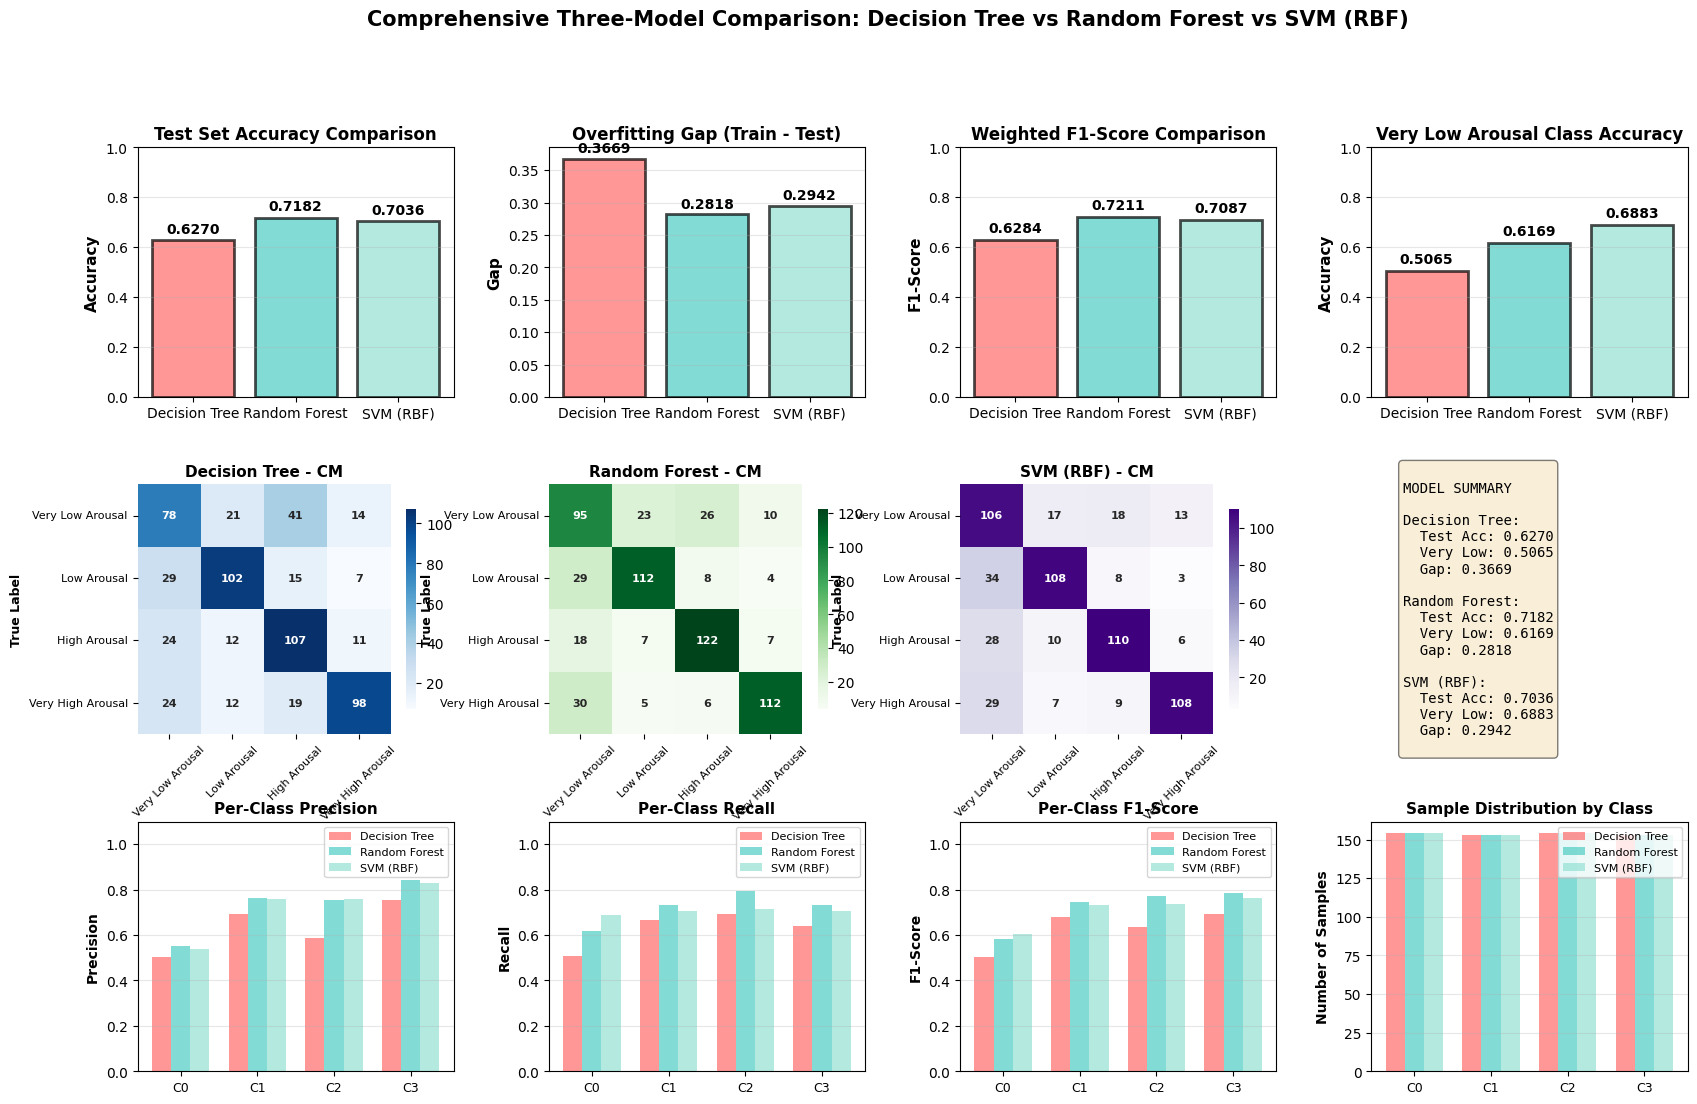


✓ Three-model comparison visualization complete


In [261]:
# ============================================
# THREE-MODEL COMPARISON (DT, RF, SVM)
# ============================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)

# Row 1: Accuracy Comparisons
# 1.1 Test Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = ['Decision Tree', 'Random Forest', 'SVM (RBF)']
test_accs = [dt_test_acc, rf_test_acc, svm_test_acc]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = ax1.bar(models, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Test Set Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, acc in enumerate(test_accs):
    ax1.text(i, acc + 0.03, f'{acc:.4f}', ha='center', fontweight='bold', fontsize=10)

# 1.2 Overfitting Gap Comparison
ax2 = fig.add_subplot(gs[0, 1])
gaps = [dt_train_acc - dt_test_acc, rf_train_acc - rf_test_acc, svm_train_acc - svm_test_acc]
bars = ax2.bar(models, gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Gap', fontsize=11, fontweight='bold')
ax2.set_title('Overfitting Gap (Train - Test)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, gap in enumerate(gaps):
    ax2.text(i, gap + 0.01, f'{gap:.4f}', ha='center', fontweight='bold', fontsize=10)

# 1.3 F1-Score Comparison
ax3 = fig.add_subplot(gs[0, 2])
f1_scores = [dt_f1_weighted, rf_f1_weighted, svm_f1_weighted]
bars = ax3.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('Weighted F1-Score Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)
for i, f1 in enumerate(f1_scores):
    ax3.text(i, f1 + 0.03, f'{f1:.4f}', ha='center', fontweight='bold', fontsize=10)

# 1.4 Very Low Arousal Accuracy
ax4 = fig.add_subplot(gs[0, 3])
very_low_accs = [
    np.sum(dt_test_pred[very_low_indices] == 0) / len(very_low_indices),
    np.sum(rf_test_pred[very_low_indices] == 0) / len(very_low_indices),
    np.sum(svm_test_pred[very_low_indices] == 0) / len(very_low_indices)
]
bars = ax4.bar(models, very_low_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Very Low Arousal Class Accuracy', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)
for i, acc in enumerate(very_low_accs):
    ax4.text(i, acc + 0.03, f'{acc:.4f}', ha='center', fontweight='bold', fontsize=10)

# Row 2: Confusion Matrices
# 2.1 Decision Tree CM
ax5 = fig.add_subplot(gs[1, 0])
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', ax=ax5,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 8, 'fontweight': 'bold'})
ax5.set_title('Decision Tree - CM', fontsize=11, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=9, fontweight='bold')
ax5.set_xlabel('Predicted Label', fontsize=9, fontweight='bold')
ax5.tick_params(axis='x', rotation=45, labelsize=8)
ax5.tick_params(axis='y', rotation=0, labelsize=8)

# 2.2 Random Forest CM
ax6 = fig.add_subplot(gs[1, 1])
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=ax6,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 8, 'fontweight': 'bold'})
ax6.set_title('Random Forest - CM', fontsize=11, fontweight='bold')
ax6.set_ylabel('True Label', fontsize=9, fontweight='bold')
ax6.set_xlabel('Predicted Label', fontsize=9, fontweight='bold')
ax6.tick_params(axis='x', rotation=45, labelsize=8)
ax6.tick_params(axis='y', rotation=0, labelsize=8)

# 2.3 SVM CM
ax7 = fig.add_subplot(gs[1, 2])
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Purples', ax=ax7,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 8, 'fontweight': 'bold'})
ax7.set_title('SVM (RBF) - CM', fontsize=11, fontweight='bold')
ax7.set_ylabel('True Label', fontsize=9, fontweight='bold')
ax7.set_xlabel('Predicted Label', fontsize=9, fontweight='bold')
ax7.tick_params(axis='x', rotation=45, labelsize=8)
ax7.tick_params(axis='y', rotation=0, labelsize=8)

# 2.4 Model Summary
ax8 = fig.add_subplot(gs[1, 3])
ax8.axis('off')

summary_text = f"""
MODEL SUMMARY

Decision Tree:
  Test Acc: {dt_test_acc:.4f}
  Very Low: {very_low_accs[0]:.4f}
  Gap: {dt_train_acc - dt_test_acc:.4f}

Random Forest:
  Test Acc: {rf_test_acc:.4f}
  Very Low: {very_low_accs[1]:.4f}
  Gap: {rf_train_acc - rf_test_acc:.4f}

SVM (RBF):
  Test Acc: {svm_test_acc:.4f}
  Very Low: {very_low_accs[2]:.4f}
  Gap: {svm_train_acc - svm_test_acc:.4f}
"""

ax8.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
        family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Row 3: Per-Class Performance
# 3.1 Per-Class Precision
ax9 = fig.add_subplot(gs[2, 0])
dt_report_dict = classification_report(y_test, dt_test_pred, target_names=class_names, output_dict=True, zero_division=0)
rf_report_dict = classification_report(y_test, rf_test_pred, target_names=class_names, output_dict=True, zero_division=0)
svm_report_dict = classification_report(y_test, svm_test_pred, target_names=class_names, output_dict=True, zero_division=0)

dt_precision_per_class = [dt_report_dict[name]['precision'] for name in class_names]
rf_precision_per_class = [rf_report_dict[name]['precision'] for name in class_names]
svm_precision_per_class = [svm_report_dict[name]['precision'] for name in class_names]

x = np.arange(len(class_names))
width = 0.25
ax9.bar(x - width, dt_precision_per_class, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax9.bar(x, rf_precision_per_class, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax9.bar(x + width, svm_precision_per_class, width, label='SVM (RBF)', alpha=0.7, color='#95E1D3')
ax9.set_ylabel('Precision', fontsize=10, fontweight='bold')
ax9.set_title('Per-Class Precision', fontsize=11, fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax9.legend(fontsize=8)
ax9.grid(axis='y', alpha=0.3)
ax9.set_ylim([0, 1.1])

# 3.2 Per-Class Recall
ax10 = fig.add_subplot(gs[2, 1])
dt_recall_per_class_arr = [dt_report_dict[name]['recall'] for name in class_names]
rf_recall_per_class_arr = [rf_report_dict[name]['recall'] for name in class_names]
svm_recall_per_class_arr = [svm_report_dict[name]['recall'] for name in class_names]

x = np.arange(len(class_names))
ax10.bar(x - width, dt_recall_per_class_arr, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax10.bar(x, rf_recall_per_class_arr, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax10.bar(x + width, svm_recall_per_class_arr, width, label='SVM (RBF)', alpha=0.7, color='#95E1D3')
ax10.set_ylabel('Recall', fontsize=10, fontweight='bold')
ax10.set_title('Per-Class Recall', fontsize=11, fontweight='bold')
ax10.set_xticks(x)
ax10.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax10.legend(fontsize=8)
ax10.grid(axis='y', alpha=0.3)
ax10.set_ylim([0, 1.1])

# 3.3 Per-Class F1-Score
ax11 = fig.add_subplot(gs[2, 2])
dt_f1_per_class = [dt_report_dict[name]['f1-score'] for name in class_names]
rf_f1_per_class = [rf_report_dict[name]['f1-score'] for name in class_names]
svm_f1_per_class = [svm_report_dict[name]['f1-score'] for name in class_names]

x = np.arange(len(class_names))
ax11.bar(x - width, dt_f1_per_class, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax11.bar(x, rf_f1_per_class, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax11.bar(x + width, svm_f1_per_class, width, label='SVM (RBF)', alpha=0.7, color='#95E1D3')
ax11.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax11.set_title('Per-Class F1-Score', fontsize=11, fontweight='bold')
ax11.set_xticks(x)
ax11.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax11.legend(fontsize=8)
ax11.grid(axis='y', alpha=0.3)
ax11.set_ylim([0, 1.1])

# 3.4 Support (Number of samples per class)
ax12 = fig.add_subplot(gs[2, 3])
dt_support = [dt_report_dict[name]['support'] for name in class_names]
rf_support = [rf_report_dict[name]['support'] for name in class_names]
svm_support = [svm_report_dict[name]['support'] for name in class_names]

x = np.arange(len(class_names))
ax12.bar(x - width, dt_support, width, label='Decision Tree', alpha=0.7, color='#FF6B6B')
ax12.bar(x, rf_support, width, label='Random Forest', alpha=0.7, color='#4ECDC4')
ax12.bar(x + width, svm_support, width, label='SVM (RBF)', alpha=0.7, color='#95E1D3')
ax12.set_ylabel('Number of Samples', fontsize=10, fontweight='bold')
ax12.set_title('Sample Distribution by Class', fontsize=11, fontweight='bold')
ax12.set_xticks(x)
ax12.set_xticklabels(['C0', 'C1', 'C2', 'C3'], fontsize=9)
ax12.legend(fontsize=8)
ax12.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Three-Model Comparison: Decision Tree vs Random Forest vs SVM (RBF)',
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

print("\n✓ Three-model comparison visualization complete")

In [262]:
print("\n" + "="*70)
print("FINAL MODEL COMPARISON AND RECOMMENDATIONS")
print("="*70)

# Create comparison dataframe
comparison_data = {
    'Model': ['Decision Tree', 'Random Forest', 'SVM (RBF)'],
    'Test Accuracy': [dt_test_acc, rf_test_acc, svm_test_acc],
    'Very Low Arousal Acc': [very_low_accs[0], very_low_accs[1], very_low_accs[2]],
    'Overfitting Gap': [dt_train_acc - dt_test_acc, rf_train_acc - rf_test_acc, svm_train_acc - svm_test_acc],
    'Weighted F1': [dt_f1_weighted, rf_f1_weighted, svm_f1_weighted],
    'Macro F1': [dt_f1_macro, rf_f1_macro, svm_f1_macro]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Rank models
print("\n" + "="*70)
print("MODEL RANKINGS")
print("="*70)

print("\nBy Overall Test Accuracy:")
for i, (model, acc) in enumerate(sorted(zip(comparison_df['Model'], comparison_df['Test Accuracy']),
                                         key=lambda x: x[1], reverse=True), 1):
    print(f"  {i}. {model}: {acc:.4f}")

print("\nBy Very Low Arousal Classification:")
for i, (model, acc) in enumerate(sorted(zip(comparison_df['Model'], comparison_df['Very Low Arousal Acc']),
                                         key=lambda x: x[1], reverse=True), 1):
    print(f"  {i}. {model}: {acc:.4f}")

print("\nBy Generalization (Lowest Overfitting Gap):")
for i, (model, gap) in enumerate(sorted(zip(comparison_df['Model'], comparison_df['Overfitting Gap']),
                                         key=lambda x: x[1]), 1):
    print(f"  {i}. {model}: {gap:.4f}")

print("\n" + "="*70)
print("RECOMMENDATIONS")
print("="*70)

best_overall = comparison_df.loc[comparison_df['Test Accuracy'].idxmax()]
best_very_low = comparison_df.loc[comparison_df['Very Low Arousal Acc'].idxmax()]
best_generalization = comparison_df.loc[comparison_df['Overfitting Gap'].idxmin()]

print(f"\nBest Overall Performance: {best_overall['Model']}")
print(f"  - Test Accuracy: {best_overall['Test Accuracy']:.4f}")
print(f"  - Recommendation: Use this model for general arousal classification")

print(f"\nBest for Very Low Arousal: {best_very_low['Model']}")
print(f"  - Very Low Acc: {best_very_low['Very Low Arousal Acc']:.4f}")
print(f"  - Recommendation: Use this model when accurate identification of low arousal is critical")

print(f"\nBest Generalization: {best_generalization['Model']}")
print(f"  - Overfitting Gap: {best_generalization['Overfitting Gap']:.4f}")
print(f"  - Recommendation: Most reliable across train and test sets")

print("\n✓ Model comparison complete!")


FINAL MODEL COMPARISON AND RECOMMENDATIONS

        Model  Test Accuracy  Very Low Arousal Acc  Overfitting Gap  Weighted F1  Macro F1
Decision Tree       0.627036              0.506494         0.366877     0.628397  0.628585
Random Forest       0.718241              0.616883         0.281759     0.721072  0.721214
    SVM (RBF)       0.703583              0.688312         0.294243     0.708680  0.708807

MODEL RANKINGS

By Overall Test Accuracy:
  1. Random Forest: 0.7182
  2. SVM (RBF): 0.7036
  3. Decision Tree: 0.6270

By Very Low Arousal Classification:
  1. SVM (RBF): 0.6883
  2. Random Forest: 0.6169
  3. Decision Tree: 0.5065

By Generalization (Lowest Overfitting Gap):
  1. Random Forest: 0.2818
  2. SVM (RBF): 0.2942
  3. Decision Tree: 0.3669

RECOMMENDATIONS

Best Overall Performance: Random Forest
  - Test Accuracy: 0.7182
  - Recommendation: Use this model for general arousal classification

Best for Very Low Arousal: SVM (RBF)
  - Very Low Acc: 0.6883
  - Recommendation